<a href="https://colab.research.google.com/github/laggyperson/URAP-Colab-ML-Notebooks/blob/main/Traffic_Prediction_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiments

In [ ]:
# # Test
# ds_range = tf.data.Dataset.range(100)
# ds_2_range = tf.data.Dataset.range(0, -100, -1)
# ds_fin = tf.data.Dataset.zip((ds_range, ds_2_range))

# ds_fin_batch = ds_fin.batch(32)
# for a, b in ds_fin_batch.take(10):
#   print(a.numpy(), "=>", b.numpy(), end="\n\n")

# print("New")
# ds_fin_shuff_batch = ds_fin.batch(32).shuffle(50)
# for a, b in ds_fin_shuff_batch.take(10):
#   print(a.numpy(), "=>", b.numpy())

In [ ]:
# # Experiment
# # Will split the inputs and labels of the features based on initial parameters
# def split_window(features):
#   inputs = features[:, slice(0, 7), :]
#   labels = features[:, slice(8, 10), :]

#   # Slicing doesn't preserve static shape information, so set the shapes
#   # manually. This way the `tf.data.Datasets` are easier to inspect.
#   inputs.set_shape([None, 7, None])
#   labels.set_shape([None, 2, None])

#   return (inputs, labels)

# data = []
# count = 1
# for _ in range(50):
#   data.append(np.array([count]))
#   count += 1

# data = np.array(data)

# ds = keras.utils.timeseries_dataset_from_array(
#         data=data,
#         targets=None,
#         sequence_length=10,
#         sequence_stride=5,
#         shuffle=False,)

# for feature in ds.take(1):
#   print(np.array(feature))

# ds = ds.map(split_window)

# # for feature, label in ds.take(1):
# #   print(np.array(feature), "=>", np.array(label))

# Preprocessing Head

Since I have 550 time series data, there will be 550 numeric preprocessing heads because every times series has their own mean and standard deviation.

In [ ]:
# Creating inputs
inputs = {}
categorical_vars = ["Traffic Light State", "Destination Edge", "Destination Reached"] # Last one is binary, but is "y" and "n", so will convert it

for label in all_xarr["Data Labels"].data:
  dtype = tf.float32
  if label in categorical_vars:
    dtype = tf.string
  inputs[label] = keras.Input(shape=(1, ), name=label, dtype=dtype)

NameError: ignored

In [ ]:
# Checking this time series
single_ts.data.shape

In [ ]:
# Handling numerical columns
# Putting together numeric input layers
numeric_inputs = {label:input for label, input in inputs.items() if input.dtype==tf.float32}

# Concatenating the layers
temp = layers.Concatenate()(list(numeric_inputs.values()))

norm = layers.Normalization()
norm.adapt(single_ts.sel({"Data Labels": list(numeric_inputs.keys())}).data.astype(float))

In [ ]:
all_numeric_inputs = norm(temp)

In [ ]:
# Categorical variables
cat_vars = [] # (# of categorical vars)
for label in categorical_vars:
  # Will only need to use one time series for creating this: more efficient (I believe)
  lookup = layers.StringLookup(vocabulary=np.unique(all_xarr.sel({"Data Labels":label}).data))
  one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())
  reshape = layers.Concatenate()

  tmp = lookup(inputs[label])
  tmp = one_hot(tmp)
  cat_vars.append(tmp)

In [ ]:
# Creating the processing heads
preprocessing_list = [all_numeric_inputs] + cat_vars
preprocessing_cat = layers.Concatenate()(preprocessing_list)
preprocessing_head = keras.Model(inputs, preprocessing_cat)

# Printing one out to check structure
tf.keras.utils.plot_model(model=preprocessing_head, rankdir="LR", dpi=108, show_shapes=True)

In [ ]:
# Saving the model
preprocessing_head.save("/content/drive/MyDrive/Colab Notebooks/preprocessing_head.keras")

# About
These are the models/experiments I will be running on the Sumo collected data.

Idea on Data:
* https://stats.stackexchange.com/questions/305863/how-to-train-lstm-model-on-multiple-time-series-data
* https://datascience.stackexchange.com/questions/67171/can-i-use-lstm-models-to-evaluate-multiple-independent-time-series
* https://medium.com/@kavyamalla/extending-tensorflows-window-generator-for-multiple-time-series-8b15eba57858

## Idea 1:
Seems like I batch together multiple vehicles and train it through the entire series. Then to test within the cycle, run a partial window through new vehicles and check the labels??

## Idea 2:
I am collecting data into `(# of vehicles across all simulations, # of time steps, data)`. I originally was normalizing according to each vehicle, but I don't think I should do that since the relative amount of traffic should be learned by normalizing across all simulation data.

I will then create the normal preprocessing head and then combine that into a model with a compile function. There will be no processing beforehand.

To further organize the data, I will split the data into 70% training, 20% validation, and 10% test. This means the first 70% of the time series data is used, so on so forth.

The way the data is organized is as follows:
Say each vehicle in each simulation has a time series that looks like
$[f_0, ..., f_{2401}]$ where $f_i$ is a vector of all the features at a certain time step.

Say that my window is 50 time steps total, split into 25 inputs and 25 labels.
$$[0, ..., 24] \rightarrow [25, ...,49]$$
If I take a stride of 25 and batch 32 sequences together, the data will look as follows:

**Batch 1:**

$[f_0, ..., f_{24}] \rightarrow [f_{25}, ..., f_{49}]$

$[f_{25}, ..., f_{49}] \rightarrow [f_{50}, ..., f_{74}]$

$\qquad \qquad \qquad \vdots$

$[f_{775}, ..., f_{799}] \rightarrow [f_{800}, ..., f_{824}]$

**Batch 2:**

$[f_{800}, ..., f_{824}] \rightarrow [f_{825}, ..., f_{849}]$

$\qquad\qquad\qquad \vdots$

**Batch 3:**

$\vdots$

After shuffling, each `input, label` pair will be shuffled around. The state of the LSTM will be reset after each batch.

This data will be normalized all together, so there is a sense of relative amounts of traffic that differs in every simulation

##Issue:
An issue that needs to be addressed is the changing destinations. It is possible that the LSTM will become confused when in the middle of an input the car suddenly switches a destination, meaning the model suddenly has to disregard the previous destination and its associated values.

### Idea 1:
Split the vehicle time series data into separate sequences that end when the vehicle reaches the destination. This would lead to variable window and input lengths that will not be padded because the lengths may vary a lot.

### Idea 2:
Batch the data the same way as before, but remove any inputs where the destination changes. Filtering the data seems to be possible.

## Improvement Ideas
* Activation Functions:
  * https://stats.stackexchange.com/questions/444923/activation-function-between-lstm-layers#:~:text=Given%20that%20ReLUs%20can%20have,inappropriate%20for%20use%20with%20LSTMs.
  * https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/

In [1]:
import signal
from contextlib import contextmanager

class TimeoutException(Exception): pass

@contextmanager
def time_limit(seconds):
    def signal_handler(signum, frame):
        raise TimeoutException("Timed out!")
    signal.signal(signal.SIGALRM, signal_handler)
    signal.alarm(seconds)
    try:
        yield
    finally:
        signal.alarm(0)

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers

# Loading the Data

In [3]:
g16_100v_noLC_shortTL_ds = xr.open_dataset("/content/drive/MyDrive/Colab Notebooks/Data/G16_100v_noLC.nc")
g16_100v_noLC_shortTL_arr = g16_100v_noLC_shortTL_ds["Data"].transpose("Veh IDs", "Time", "Data Labels")

g16_100v_LC_shortTL_ds = xr.open_dataset("/content/drive/MyDrive/Colab Notebooks/Data/G16_100v_LC.nc")
g16_100v_LC_shortTL_arr = g16_100v_LC_shortTL_ds["Data"].transpose("Veh IDs", "Time", "Data Labels")

g16_100v_LC_longTL_ds = xr.open_dataset("/content/drive/MyDrive/Colab Notebooks/Data/G16_100v_LC_longTL.nc")
g16_100v_LC_longTL_arr = g16_100v_LC_longTL_ds["Data"].transpose("Veh IDs", "Time", "Data Labels")

g16_50v_LC_longTL_ds = xr.open_dataset("/content/drive/MyDrive/Colab Notebooks/Data/G16_50v_LC_longTL.nc")
g16_50v_LC_longTL_arr = g16_50v_LC_longTL_ds["Data"].transpose("Veh IDs", "Time", "Data Labels")

g16_200v_LC_longTL_ds = xr.open_dataset("/content/drive/MyDrive/Colab Notebooks/Data/G16_200v_LC_longTL.nc")
g16_200v_LC_longTL_arr = g16_200v_LC_longTL_ds["Data"].transpose("Veh IDs", "Time", "Data Labels")

# List of all arrays
arrs = [g16_100v_noLC_shortTL_arr, g16_100v_LC_shortTL_arr, g16_100v_LC_longTL_arr, g16_50v_LC_longTL_arr, g16_200v_LC_longTL_arr]

In [4]:
# Concatenating
all_xarr = xr.concat(arrs, dim="Veh IDs")

In [5]:
# Offloading RAM since arrs not needed anymore
del g16_100v_noLC_shortTL_ds
del g16_100v_noLC_shortTL_arr
del g16_100v_LC_shortTL_ds
del g16_100v_LC_shortTL_arr

del g16_100v_LC_longTL_ds
del g16_100v_LC_longTL_arr

del g16_50v_LC_longTL_ds
del g16_50v_LC_longTL_arr

del g16_200v_LC_longTL_ds
del g16_200v_LC_longTL_arr

del arrs

# Preprocessing
Faster than preprocessing head

In [6]:
categorical_vars = ["Traffic Light State", "Destination Edge", "Destination Reached"] # Last one is binary, but is "y" and "n", so will convert it
numeric_vars = [label for label in all_xarr["Data Labels"].data if label not in categorical_vars]

In [7]:
# New label order
labels = numeric_vars + categorical_vars
print(len(labels))

22


In [8]:
for i in range(len(labels)):
  print(i, labels[i])

0 Speed
1 Max Speed
2 Acceleration
3 Traffic Light Distance
4 Traffic Light Time to Switch
5 Number of Vehicles to Traffic Light
6 Number of Leading Vehicles
7 Leading Vehicles Average Gap
8 Leading Vehicles Average Speed
9 Leading Vehicles Average Acceleration
10 Number of Right Lane Vehicles
11 Right Lane Average Gap
12 Right Lane Average Speed
13 Right Lane Average Acceleration
14 Number of Left Lane Vehicles
15 Left Lane Average Gap
16 Left Lane Average Speed
17 Left Lane Average Acceleration
18 Distance to Edge
19 Traffic Light State
20 Destination Edge
21 Destination Reached


In [9]:
# Getting numerical data into correct shape
single_ts = all_xarr.sel({"Data Labels": numeric_vars}).data.astype(float)
single_ts = np.concatenate(single_ts)

# Data to Normalize
numerical_data = all_xarr.sel({"Data Labels": numeric_vars}).data.astype(float)

In [10]:
# Getting rid of bad values from Distance to Edge
temp = single_ts[:, -1]
temp[temp < 0] = 0

temp = numerical_data[:, :, -1]
temp[temp < 0] = 0

In [11]:
# Preprocessing manually
num_mean = np.mean(single_ts, axis=0)
num_std = np.std(single_ts, axis=0)
numerical_data = (numerical_data - num_mean) / num_std

In [12]:
# Loading all categorical data into separate arrays
categorical_data_TL_state = all_xarr.sel({"Data Labels": "Traffic Light State"}).data
categorical_data_dest = all_xarr.sel({"Data Labels": "Destination Edge"}).data
categorical_data_reached = all_xarr.sel({"Data Labels": "Destination Reached"}).data

cat_dict = {
    "Traffic Light State": categorical_data_TL_state,
    "Destination Edge": categorical_data_dest,
    "Destination Reached": categorical_data_reached
}

In [13]:
# Encoding all the data
for label in categorical_vars:
  curr_arr = cat_dict[label]
  vocab = np.unique(curr_arr)
  encode = layers.StringLookup(vocabulary=vocab, output_mode="one_hot")
  encodings = encode(vocab).numpy()
  trans_dict = {vocab[i]: encodings[i] for i in range(len(vocab))}

  new_arr = []
  for ts in curr_arr:
    new_arr.append(np.array([trans_dict[w] for w in ts]))
  cat_dict[label] = np.array(new_arr)

In [14]:
print(cat_dict["Traffic Light State"].shape)

(550, 2401, 5)


In [15]:
# Recombining all categorical data data
categorical_data = np.concatenate(list(cat_dict.values()), axis=-1)
categorical_data.shape # The final dimension will be (TL State, Destination Edge, Destination Reached)

(550, 2401, 25)

In [16]:
# Recombining all data into a single numpy array
all_data = np.concatenate((numerical_data, categorical_data), axis=-1)
all_data.shape # CHecking proper shape

(550, 2401, 44)

In [17]:
# Splitting the Data into training and test sets
# Distribution: 70% training, 20% validation, 10% test

steps = len(all_data[0])
# Slices
train_slice = slice(0, int(0.7 * steps))
validate_slice = slice(int(0.7 * steps), int(0.9 * steps))
test_slice = slice(int(0.9 * steps), None)
# Splitting each individual set
slice_func = lambda data, s: data[s]
train_ts = all_data[:, train_slice, :]
validate_ts = all_data[:, validate_slice, :]
test_ts = all_data[:, test_slice, :]

In [18]:
print(train_ts.shape, validate_ts.shape, test_ts.shape)

(550, 1680, 44) (550, 480, 44) (550, 241, 44)


In [19]:
# # Clearing RAM
# del categorical_data_TL_state
# del categorical_data_reached
# del categorical_data_dest
# del cat_dict
# del all_xarr
# del curr_arr
# del encode
# del encodings
# del label
# del new_arr
# del num_mean
# del num_std
# del numerical_data
# del categorical_data
# del ts
# del vocab
# del single_ts
# del all_data
# del categorical_vars
# del numeric_vars
# del steps

# Windowing + Batching

In [20]:
# Creating a Window class

class WindowGenerator():
  def __init__(self, input_width, label_width, shift, stride,
               train_data, val_data, test_data, all_labels, input_columns=None, label_columns=None):
    # Windows intialized with data
    self.train_data = train_data
    self.val_data = val_data
    self.test_data = test_data

    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift
    self.stride = stride

    self.all_labels = all_labels
    self.column_indices = {all_labels[i]: slice(i, i + 1) for i in range(len(all_labels))}
    self.column_indices['Traffic Light State'] = slice(self.column_indices['Traffic Light State'].start, self.column_indices['Traffic Light State'].start + 5)
    self.column_indices["Destination Edge"] = slice(self.column_indices["Destination Edge"].start, self.column_indices["Destination Edge"].start + 19)
    self.column_indices["Destination Reached"] = slice(len(all_labels) - 1, None)

    if input_columns is not None:
      self.input_columns = input_columns
    else:
      self.input_columns = all_labels

    self.label_columns = label_columns

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    self.count = 0

  def make_window(self, time_series):
    # Input Shape: (2401, 44) = (# of time steps, # of features)
    # Output Shape: (# of windows, # of time steps per window, # of features)
    w_start, w_end = 0, self.total_window_size
    stride = self.stride

    res = []
    while w_end < len(time_series):
      window = time_series[w_start: w_end]
      if 1 not in window[:, -1]:
        res.append(window)
      w_start += stride
      w_end += stride

    return res

  def make_dataset(self, data):
    # The data is in the shape (550, 2401, 44) = (# of veh series, # of time steps, preprocessed features)
    # The returned dataset should be in the shape:
    # (_, 2) = (# of batches, dimension of each example)
    # Each example: ((32, 40, 44), (32, 40, 2)) = (features, labels)
    # = ((# of examples per batch, # of time steps in input, # of features in input), (# of examples per batch, # of time steps in labels, # of features in labels))

    # Window each time series
    # Output Shape: (550, # of windows, # of time steps per window, # of features=44)
    # Issue: Non homogenous 2nd dimension (each time series may have different amount of filtered windows): can't use numpy
    data = [self.make_window(ts) for ts in data]

    # Stacking all windows together
    # Shape: (# of windows, # of time stps per window, # of features=44)
    data = np.array([win for ts in data for win in ts])

    # Get the features
    # (# of windows, # of time steps, # of features)
    feature_examples = data[:, self.input_slice, :]
    feature_examples = np.concatenate([feature_examples[:, :, self.column_indices[label]] for label in self.input_columns], -1)

    # Get the labels
    label_examples = data[:, self.labels_slice, :]
    if self.label_columns is not None:
      label_examples = np.concatenate([label_examples[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Make the dataset
    ds = tf.data.Dataset.from_tensor_slices((feature_examples, label_examples))
    ds = ds.batch(32).shuffle(100)
    return ds

  def plot(self, data, model=None, plot_col='Distance to Edge', max_subplots=3):
    plt.figure(figsize=(12, 3 * max_subplots)) # Setting size: will dynamically resize based on the number of subplots
    plot_col_index = self.column_indices[plot_col] # Index of which feature to plot

    # Plotting each subplot
    plot_num = 1 # Keep track of which plot is current
    for input, label in data.take(max_subplots): # Grabbing feature and data
      plt.subplot(max_subplots, 1, plot_num) # Specify which one currently plotting

      plt.ylabel(f'{plot_col} [normed]') # Label y axis

      plt.plot(self.input_indices, input.numpy()[plot_num, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)  # Plot the blue line that represents the input

      # Finding feature index to extract from the returned labels (since it may differ in shape than the input)
      if self.label_columns:
        label_col_index = self.column_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None: # If it isn't found
        continue

      plt.scatter(self.label_indices, label.numpy()[plot_num, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64) # Plot the expected labels as green dots
      if model is not None: # Using model to make predictions
        predictions = model(input) # Calling model on inputs
        plt.scatter(self.label_indices, predictions[plot_num, :, label_col_index], # Plotting predictions, extracting the label wanted
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if plot_num == 1: # First plot we want to plot the legend
        plt.legend()

      plot_num += 1

    plt.xlabel('Time (s)') # Label x-axis


  @property
  def train(self):
    return self.make_dataset(self.train_data)

  @property
  def val(self):
    return self.make_dataset(self.val_data)

  @property
  def test(self):
    return self.make_dataset(self.test_data)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.test))
      # And cache it for next time
      self._example = result
    return result

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [21]:
# Removing all Traffic Light Data
input_labels = [label for label in labels if label not in ["Number of Vehicles to Traffic Light", "Destination Edge", "Destination Reached"]]
output_labels = [label for label in input_labels if label not in ["Traffic Light Distance", "Traffic Light State", "Traffic Light Time to Switch"]]

In [22]:
# Testing windows + batching
w0 = WindowGenerator(80, 80, 80, 20, train_ts, validate_ts, test_ts, labels, input_labels, output_labels)

In [23]:
test_ds = w0.test
train_ds = w0.train
val_ds = w0.val

In [24]:
print(train_ds)

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 80, 23), dtype=tf.float64, name=None), TensorSpec(shape=(None, 80, 16), dtype=tf.float64, name=None))>


In [ ]:
# for feature, label in test_ds.take(10):
#   plt.figure(figsize=(10, 2))
#   plt.plot(np.arange(40), feature.numpy()[0, :, 18])
#   plt.plot(np.arange(40,80), label.numpy()[0, :, 1])
#   plt.show()

# Model Template

In [25]:
MAX_EPOCHS = 20

def compile_and_fit(model, train, validate, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(train, epochs=MAX_EPOCHS,
                      validation_data=validate,
                      callbacks=[early_stopping])
  return history

In [26]:
OUTPUT_STEPS = 80
num_features = 16

# Model #1: Simple LSTM, Single-Shot Prediction

In [ ]:
simple_lstm = keras.Sequential([
    layers.LSTM(32, return_sequences=False),

    # Creating output dimension: should be number of steps to predict times the number of features
    layers.Dense(OUTPUT_STEPS * num_features,
                 kernel_initializer=tf.initializers.zeros()),
    layers.Reshape([OUTPUT_STEPS, num_features])
])

In [ ]:
# Adding preprocessing head
history = compile_and_fit(simple_lstm, train_ds, val_ds)

Epoch 1/40
1104/1104 [==============================] - 31s 25ms/step - loss: 0.2896 - mean_absolute_error: 0.2739 - val_loss: 0.2695 - val_mean_absolute_error: 0.2537
Epoch 2/40
1104/1104 [==============================] - 27s 24ms/step - loss: 0.2481 - mean_absolute_error: 0.2450 - val_loss: 0.2483 - val_mean_absolute_error: 0.2382
Epoch 3/40
1104/1104 [==============================] - 27s 25ms/step - loss: 0.2366 - mean_absolute_error: 0.2343 - val_loss: 0.2403 - val_mean_absolute_error: 0.2314
Epoch 4/40
1104/1104 [==============================] - 28s 25ms/step - loss: 0.2312 - mean_absolute_error: 0.2277 - val_loss: 0.2373 - val_mean_absolute_error: 0.2249
Epoch 5/40
1104/1104 [==============================] - 29s 26ms/step - loss: 0.2280 - mean_absolute_error: 0.2237 - val_loss: 0.2342 - val_mean_absolute_error: 0.2206
Epoch 6/40
1104/1104 [==============================] - 29s 27ms/step - loss: 0.2259 - mean_absolute_error: 0.2209 - val_loss: 0.2328 - val_mean_absolute_error:

In [ ]:
simple_lstm.evaluate(test_ds)

126/126 [==============================] - 1s 7ms/step - loss: 0.2322 - mean_absolute_error: 0.2193


[0.2321501076221466, 0.21933533251285553]

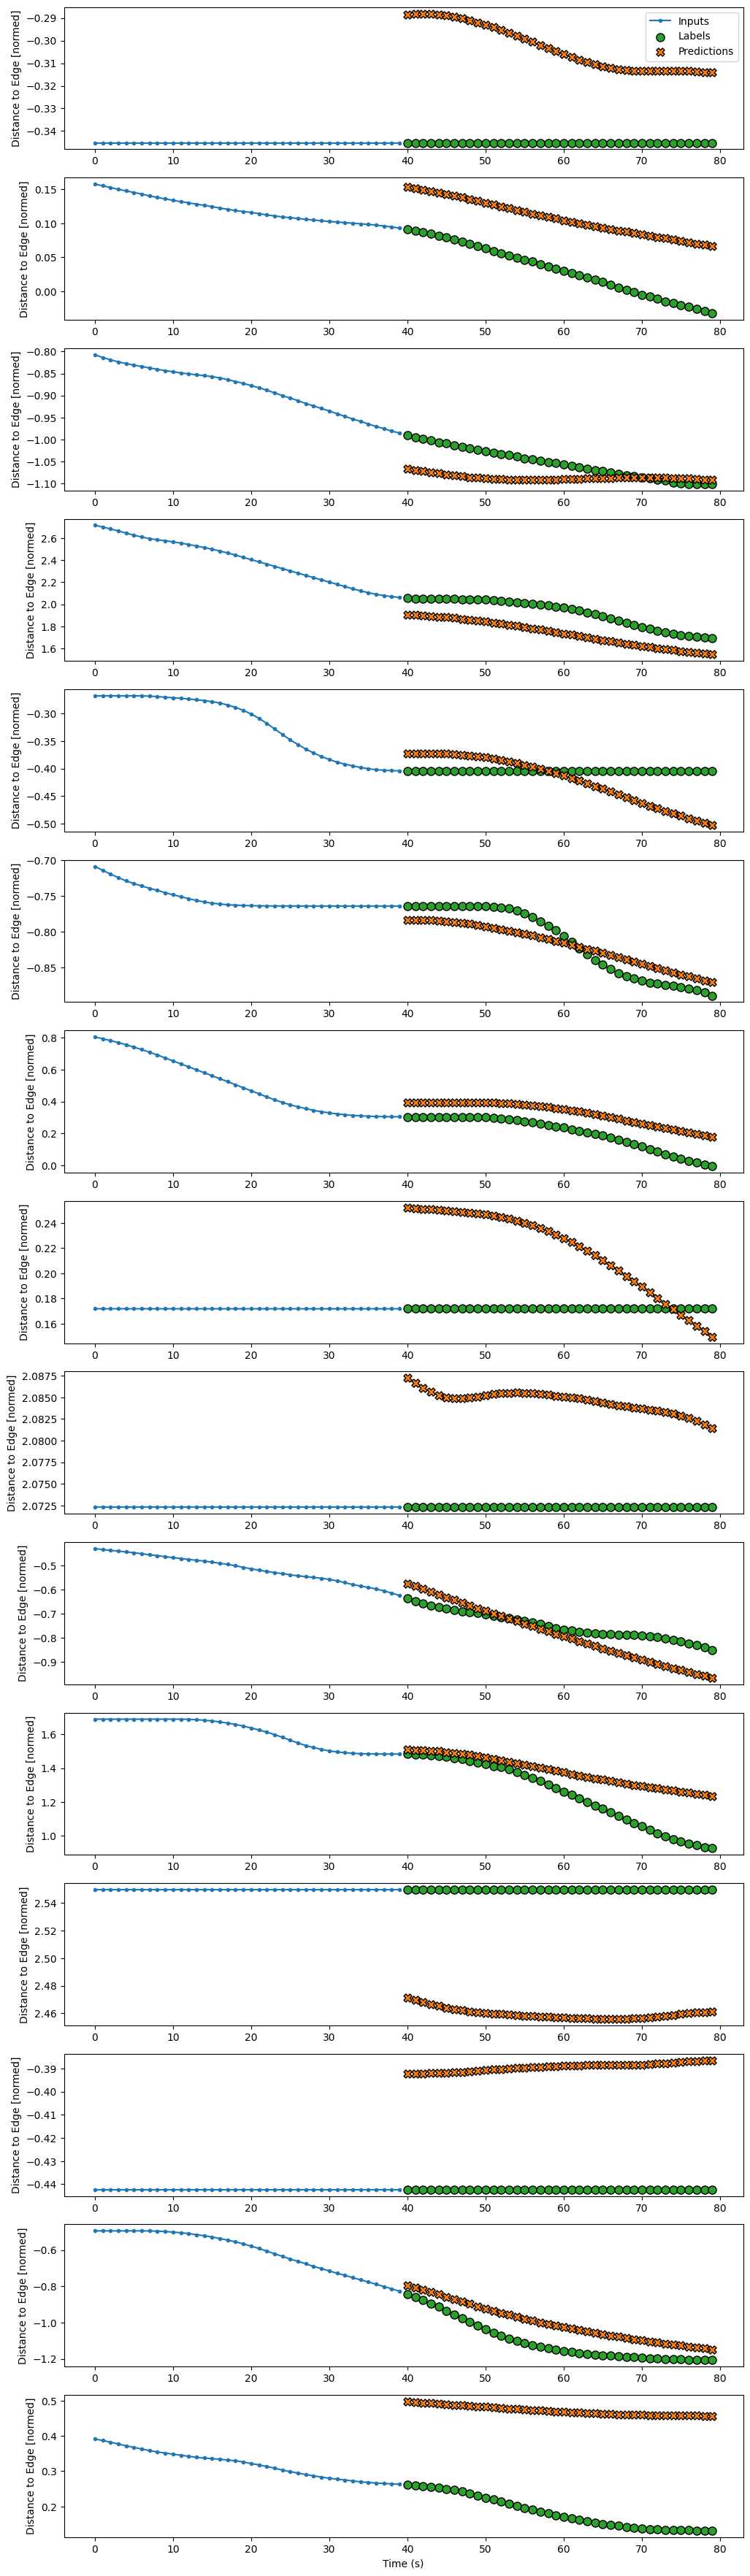

In [ ]:
w0.plot(test_ds, simple_lstm, max_subplots=15)

# Model #2: Simple LSTM, Autoregressive Prediction

## For hiding the model

In [ ]:
# Feedback model
class Feedback(keras.Model):
  def __init__(self, units, label_output_steps, num_pred_features):
    super().__init__()
    self.units = units
    self.label_output_steps = label_output_steps
    self.lstm_cell = layers.LSTMCell(units)
    self.lstm_rnn = layers.RNN(self.lstm_cell, return_state=True)
    self.dense = layers.Dense(num_pred_features) # Outputs 1 time step at a time

  # For making predictions, this will make the first prediction given the input
  # Will return the state for the model to use
  def warmup(self, input):
    prediction, *state = self.lstm_rnn(input)

    # Feed it through the dense model to get output
    prediction = self.dense(prediction)

    return prediction, state

  # Call model on inputs and make predictions
  # This method is for training
  def call(self, input, training=None):
    predictions = []
    # Warm up
    prediction, state = self.warmup(input)
    predictions.append(prediction)


    for _ in range(1, self.label_output_steps):
      tmp = prediction
      tmp, state = self.lstm_cell(tmp, states=state, training=training)

      prediction = self.dense(tmp)
      predictions.append(prediction)

    # (time, batch size, features)
    predictions = tf.stack(predictions)
    # (batch size, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])

    return predictions

  """
  Variable length output call to the model. Stops when destination predicted to be reached

  Params:
    Tensor input : input example
    float threshold : value to determine when to round a predicted value for "Destination Reached" or "Distance to Edge" label
  Ret:
    Tensor predictions : the resulting predictions (time steps, features)
  """
  def var_length_call(self, input, tolerance=-1.3):
    predictions = []

    # Warm up
    input = np.array([input[0]])
    prediction, state = self.warmup(input)

    # Keeps track of labels
    distance = prediction.numpy()[:, 18]
    predictions.append(distance)
    while distance > tolerance:
      tmp = prediction
      tmp, state = self.lstm_cell(tmp, states=state)

      prediction = self.dense(tmp)
      distance = prediction.numpy()[:, 18]

      predictions.append(distance)

    return predictions

In [ ]:
test_lstm_feedback = Feedback(64, OUTPUT_STEPS, num_features)

In [ ]:
test_lstm_feedback.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [ ]:
test_lstm_feedback.load_weights('/content/drive/MyDrive/Colab Notebooks/model/biggerLSTM_80sWind_NoDestorReached_AutoReg')

In [ ]:
test_lstm_feedback.evaluate(test_ds_full)

56/56 [==============================] - 7s 48ms/step - loss: 0.3854 - mean_absolute_error: 0.3396


[0.38544437289237976, 0.33961132168769836]

In [ ]:
pred = []
for input, label in test_ds_full.take(1):
  pred = test_lstm_feedback.var_length_call(input)

print(len(pred))

111


In [ ]:
pred = np.array(pred)

In [ ]:
print(pred.shape)

(111, 1)


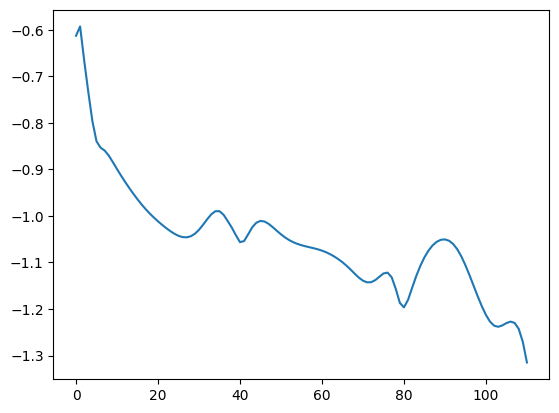

In [ ]:
plt.plot(pred)

## End hiding model

In [ ]:
w1 = WindowGenerator(80, 80, 80, 20, train_ts, validate_ts, test_ts, labels[:-2], labels[:-2])

In [ ]:
train_ds_full = w1.train
val_ds_full = w1.val
test_ds_full = w1.test

In [ ]:
print(train_ds_full)

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 80, 24), dtype=tf.float64, name=None), TensorSpec(shape=(None, 80, 24), dtype=tf.float64, name=None))>


In [ ]:
# Making the model
simple_lstm_feedback = Feedback(64, OUTPUT_STEPS, num_features)

In [ ]:
history_1 = compile_and_fit(simple_lstm_feedback, train_ds_full, val_ds_full, patience=20)

Epoch 1/20
825/825 [==============================] - 122s 116ms/step - loss: 0.5863 - mean_absolute_error: 0.4846 - val_loss: 0.6248 - val_mean_absolute_error: 0.4594
Epoch 2/20
825/825 [==============================] - 96s 117ms/step - loss: 0.5548 - mean_absolute_error: 0.4647 - val_loss: 0.5832 - val_mean_absolute_error: 0.4393
Epoch 3/20
825/825 [==============================] - 94s 114ms/step - loss: 0.5286 - mean_absolute_error: 0.4472 - val_loss: 0.5458 - val_mean_absolute_error: 0.4240
Epoch 4/20
825/825 [==============================] - 89s 108ms/step - loss: 0.5108 - mean_absolute_error: 0.4344 - val_loss: 0.5185 - val_mean_absolute_error: 0.4112
Epoch 5/20
825/825 [==============================] - 96s 116ms/step - loss: 0.4913 - mean_absolute_error: 0.4196 - val_loss: 0.5111 - val_mean_absolute_error: 0.4004
Epoch 6/20
825/825 [==============================] - 94s 114ms/step - loss: 0.4811 - mean_absolute_error: 0.4104 - val_loss: 0.4879 - val_mean_absolute_error: 0.38

In [ ]:
simple_lstm_feedback.save_weights("/content/drive/MyDrive/Colab Notebooks/model/biggerLSTM_80sWind_NoDestorReached_AutoReg")

In [ ]:
simple_lstm_feedback.evaluate(test_ds_full)

56/56 [==============================] - 2s 29ms/step - loss: 0.3854 - mean_absolute_error: 0.3396


[0.3854443430900574, 0.33961135149002075]

In [ ]:
w1.plot(train_ds_full, simple_lstm_feedback, plot_col="Distance to Edge", max_subplots=10)

# Model #3: Bigger LSTM Layers, Single-Shot Prediction
Currently the best

More LSTM units, same amount of dense layers

In [ ]:
(0 - num_mean[-1])/num_std[-1]

-1.4165352500741601

In [ ]:
num_mean[-1]

563.2819276780536

In [ ]:
num_std[-1]

397.64766012604633

In [ ]:
bigger_LSTM = keras.Sequential([
    layers.LSTM(64, return_sequences=False),

    layers.Dense(OUTPUT_STEPS * num_features,
                 kernel_initializer = tf.initializers.zeros()),

    layers.Reshape((OUTPUT_STEPS, num_features))
])

In [ ]:
history = compile_and_fit(bigger_LSTM, train_ds, val_ds, patience=20)

Epoch 1/20
825/825 [==============================] - 53s 61ms/step - loss: 0.5821 - mean_absolute_error: 0.4483 - val_loss: 0.5373 - val_mean_absolute_error: 0.3741
Epoch 2/20
825/825 [==============================] - 51s 62ms/step - loss: 0.5315 - mean_absolute_error: 0.4109 - val_loss: 0.5232 - val_mean_absolute_error: 0.3640
Epoch 3/20
825/825 [==============================] - 49s 59ms/step - loss: 0.5156 - mean_absolute_error: 0.4001 - val_loss: 0.5097 - val_mean_absolute_error: 0.3618
Epoch 4/20
825/825 [==============================] - 51s 62ms/step - loss: 0.5051 - mean_absolute_error: 0.3932 - val_loss: 0.5001 - val_mean_absolute_error: 0.3520
Epoch 5/20
825/825 [==============================] - 51s 61ms/step - loss: 0.4978 - mean_absolute_error: 0.3891 - val_loss: 0.4976 - val_mean_absolute_error: 0.3513
Epoch 6/20
825/825 [==============================] - 52s 63ms/step - loss: 0.4925 - mean_absolute_error: 0.3861 - val_loss: 0.4928 - val_mean_absolute_error: 0.3546
Epoc

In [ ]:
# bigger_LSTM.save('/content/drive/MyDrive/Colab Notebooks/model/biggerLSTM_80sWind_NoCatVarsOrTLData.keras')

In [27]:
bigger_LSTM = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/model/biggerLSTM_80sWind_NoCatVarsOrTLData.keras")

In [ ]:
bigger_LSTM.evaluate(test_ds)

56/56 [==============================] - 2s 36ms/step - loss: 0.4325 - mean_absolute_error: 0.3511


[0.43251508474349976, 0.3510524034500122]

ValueError: ignored

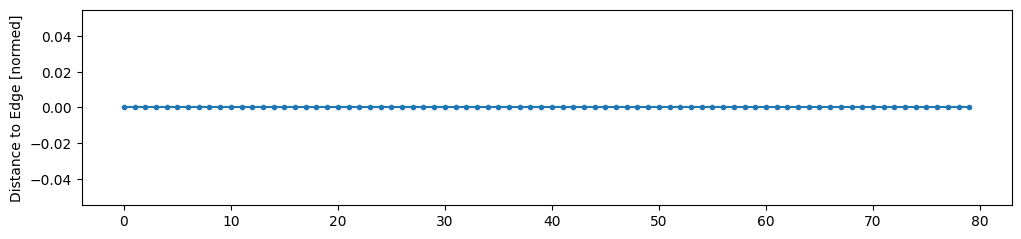

In [ ]:
w0.plot(test_ds, bigger_LSTM, plot_col="Distance to Edge", max_subplots=10)

# Model #3.5: Even Bigger LSTM, Single-Shot Prediction

In [ ]:
even_bigger_LSTM = keras.Sequential([
    layers.LSTM(128, return_sequences=False),

    layers.Dense(OUTPUT_STEPS * num_features,
                 kernel_initializer=tf.initializers.zeros()),
    layers.Reshape([OUTPUT_STEPS, num_features])
])

In [ ]:
history = compile_and_fit(even_bigger_LSTM, train_ds, val_ds)

Epoch 1/40
825/825 [==============================] - 151s 178ms/step - loss: 0.2633 - mean_absolute_error: 0.2538 - val_loss: 0.2405 - val_mean_absolute_error: 0.2244
Epoch 2/40
825/825 [==============================] - 143s 173ms/step - loss: 0.2270 - mean_absolute_error: 0.2180 - val_loss: 0.2383 - val_mean_absolute_error: 0.2142
Epoch 3/40
825/825 [==============================] - 154s 187ms/step - loss: 0.2163 - mean_absolute_error: 0.2069 - val_loss: 0.2302 - val_mean_absolute_error: 0.2071
Epoch 4/40
825/825 [==============================] - 158s 192ms/step - loss: 0.2083 - mean_absolute_error: 0.1992 - val_loss: 0.2215 - val_mean_absolute_error: 0.2010
Epoch 5/40
825/825 [==============================] - 148s 179ms/step - loss: 0.2031 - mean_absolute_error: 0.1944 - val_loss: 0.2192 - val_mean_absolute_error: 0.1977
Epoch 6/40
825/825 [==============================] - 188s 228ms/step - loss: 0.1993 - mean_absolute_error: 0.1911 - val_loss: 0.2184 - val_mean_absolute_error:

In [ ]:
even_bigger_LSTM.evaluate(test_ds)

56/56 [==============================] - 5s 81ms/step - loss: 0.1934 - mean_absolute_error: 0.1956


[0.19335927069187164, 0.19563882052898407]

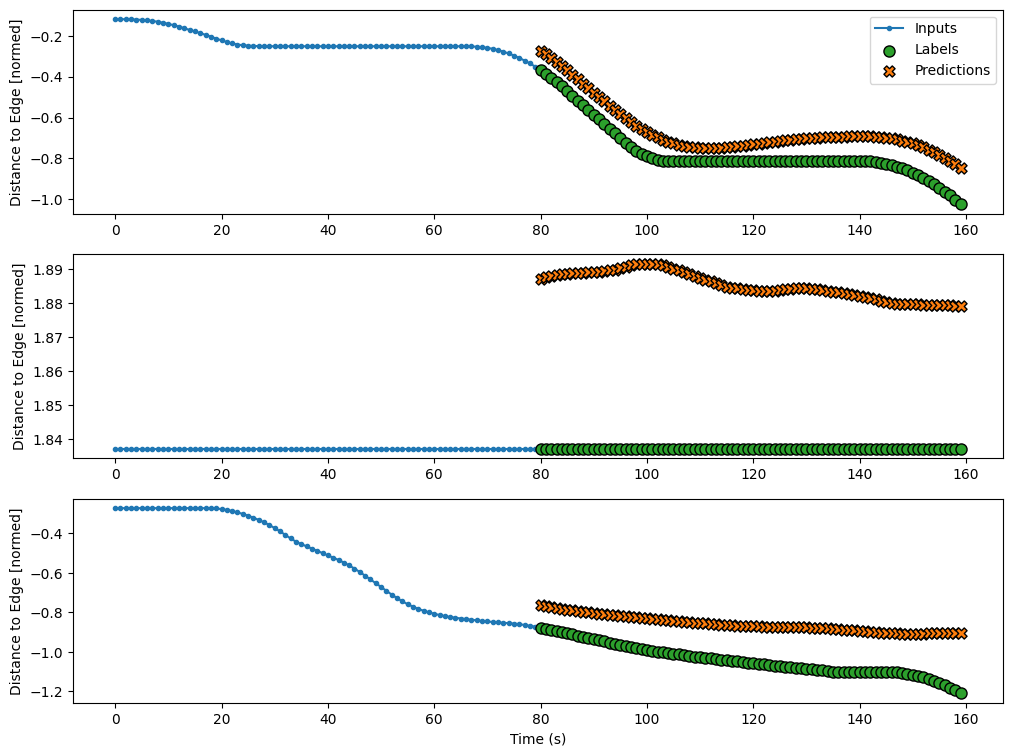

In [ ]:
w0.plot(test_ds, even_bigger_LSTM, plot_col="Distance to Edge")

In [ ]:
even_bigger_LSTM.save("/content/drive/MyDrive/Colab Notebooks/model/evenBiggerLSTM.keras")

# Model #4: Denser LSTM, Single-shot Prediction

Too lineaer of predictions

In [ ]:
denser_LSTM = keras.Sequential([
    layers.LSTM(32, return_sequences=True),
    layers.LSTM(32, return_sequences=True),
    layers.LSTM(32, return_sequences=True),
    layers.LSTM(32, return_sequences=True),
    layers.LSTM(32, return_sequences=False),

    layers.Dense(OUTPUT_STEPS * num_features,
                 kernel_initializer = tf.initializers.zeros()),

    layers.Reshape((OUTPUT_STEPS, num_features))
])

In [ ]:
history = compile_and_fit(denser_LSTM, train_ds, val_ds)

Epoch 1/20
553/553 [==============================] - 77s 116ms/step - loss: 0.0938 - mean_absolute_error: 0.2070 - val_loss: 0.0474 - val_mean_absolute_error: 0.1722
Epoch 2/20
553/553 [==============================] - 61s 111ms/step - loss: 0.0161 - mean_absolute_error: 0.0937 - val_loss: 0.0151 - val_mean_absolute_error: 0.0910
Epoch 3/20
553/553 [==============================] - 60s 108ms/step - loss: 0.0121 - mean_absolute_error: 0.0822 - val_loss: 0.0117 - val_mean_absolute_error: 0.0742
Epoch 4/20
553/553 [==============================] - 58s 105ms/step - loss: 0.0166 - mean_absolute_error: 0.0903 - val_loss: 0.0278 - val_mean_absolute_error: 0.1254
Epoch 5/20
553/553 [==============================] - 60s 108ms/step - loss: 0.0103 - mean_absolute_error: 0.0744 - val_loss: 0.0105 - val_mean_absolute_error: 0.0715
Epoch 6/20
553/553 [==============================] - 58s 105ms/step - loss: 0.0107 - mean_absolute_error: 0.0736 - val_loss: 0.0237 - val_mean_absolute_error: 0.122

In [ ]:
denser_LSTM.evaluate(test_ds)

70/70 [==============================] - 4s 57ms/step - loss: 0.0480 - mean_absolute_error: 0.1406


[0.04803795740008354, 0.14057014882564545]

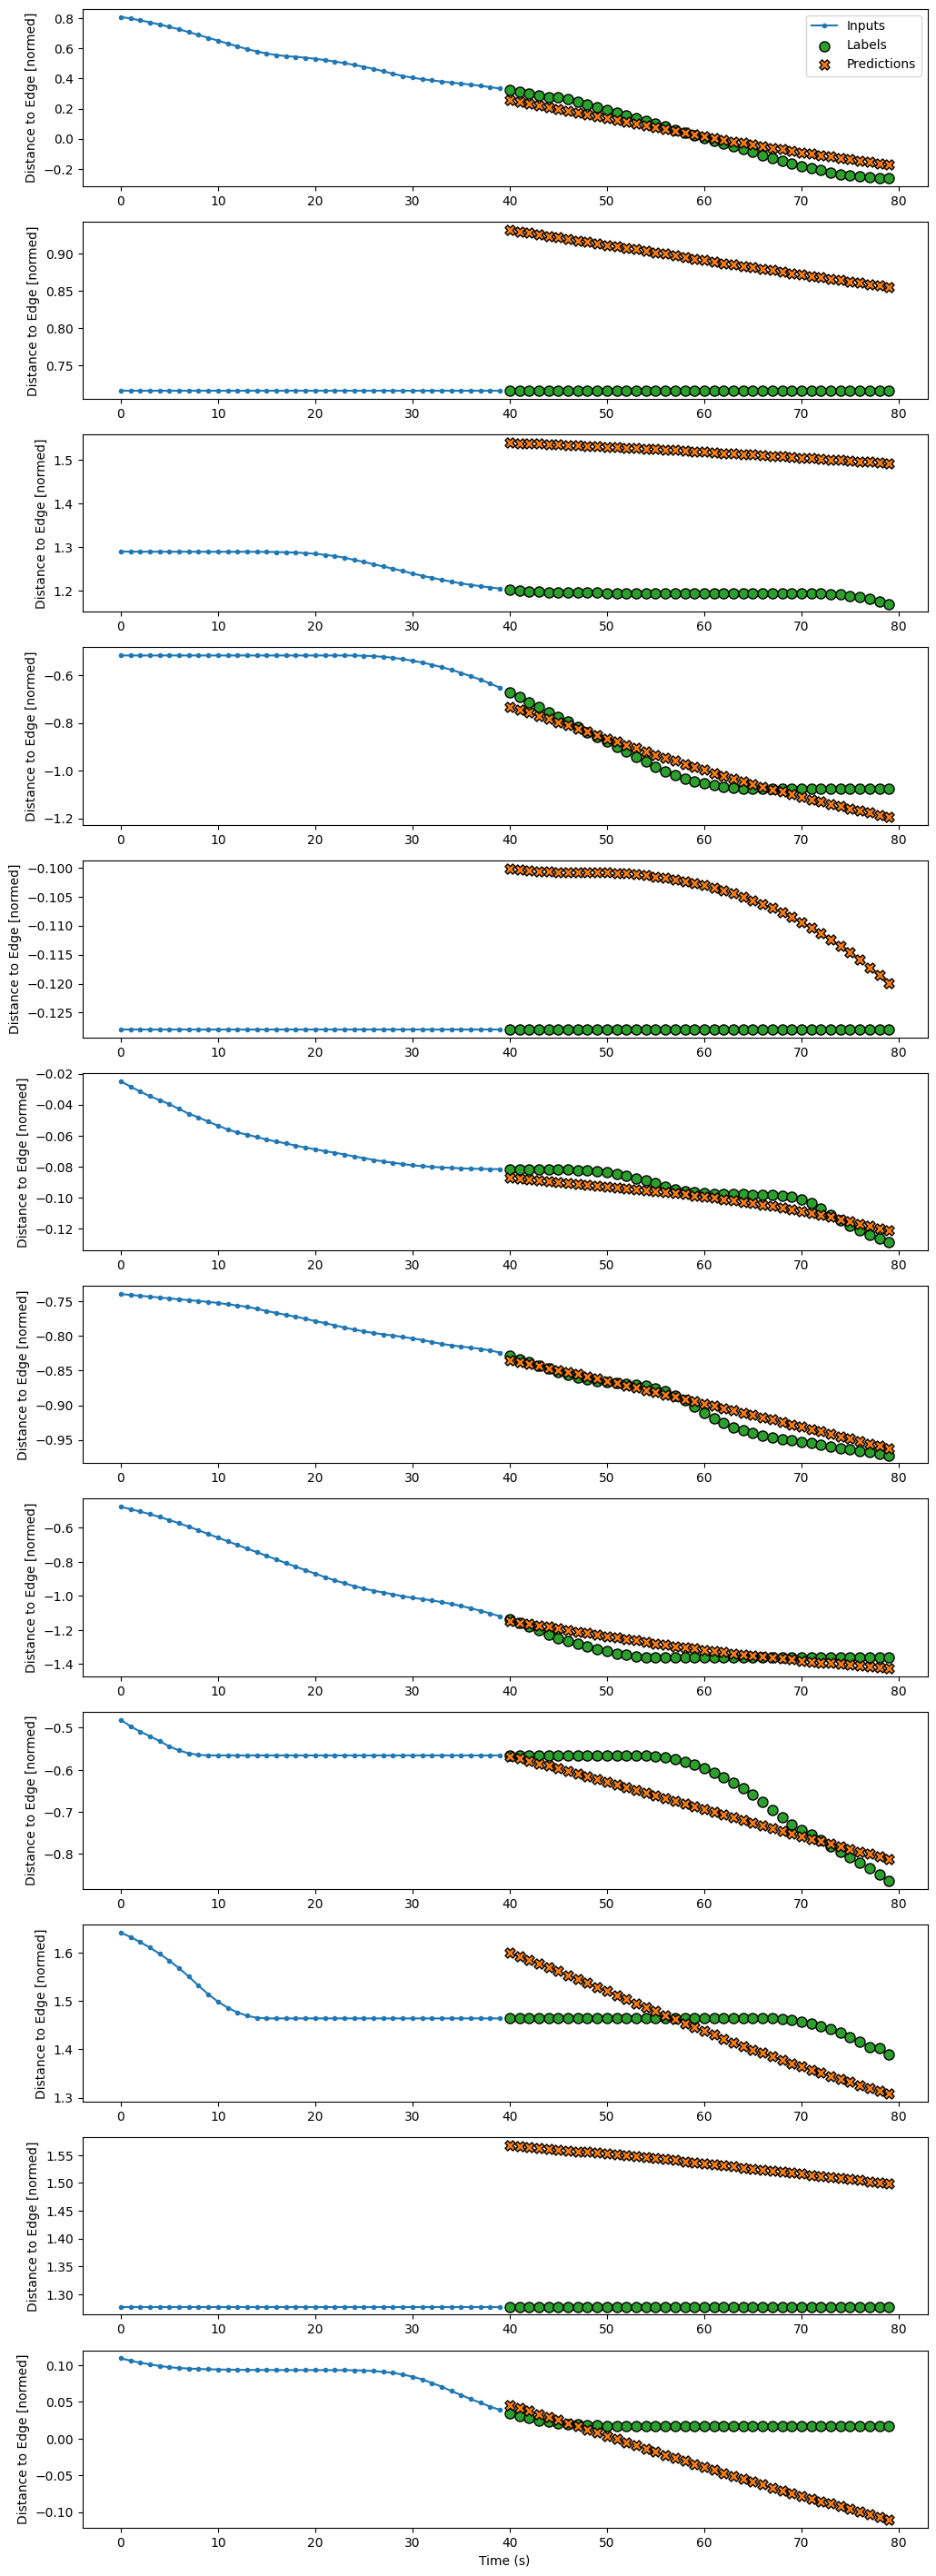

In [ ]:
w0.plot(val_ds, denser_LSTM, plot_col="Distance to Edge", max_subplots=12)

# Model #5: Bigger LSTM Layers, Autoregressive Prediction

In [ ]:
bigger_lstm_feedback = Feedback(128, OUTPUT_STEPS, 44)

In [ ]:
history = compile_and_fit(bigger_lstm_feedback, train_ds_full, val_ds_full)

Epoch 1/20
688/688 [==============================] - 122s 161ms/step - loss: 0.3385 - mean_absolute_error: 0.3097 - val_loss: 0.3232 - val_mean_absolute_error: 0.2864
Epoch 2/20
688/688 [==============================] - 108s 157ms/step - loss: 0.3021 - mean_absolute_error: 0.2819 - val_loss: 0.3004 - val_mean_absolute_error: 0.2725
Epoch 3/20
688/688 [==============================] - 107s 156ms/step - loss: 0.2809 - mean_absolute_error: 0.2652 - val_loss: 0.2884 - val_mean_absolute_error: 0.2617
Epoch 4/20
688/688 [==============================] - 107s 155ms/step - loss: 0.2687 - mean_absolute_error: 0.2563 - val_loss: 0.2829 - val_mean_absolute_error: 0.2593
Epoch 5/20
688/688 [==============================] - 107s 155ms/step - loss: 0.2595 - mean_absolute_error: 0.2498 - val_loss: 0.2684 - val_mean_absolute_error: 0.2519
Epoch 6/20
688/688 [==============================] - 107s 155ms/step - loss: 0.2510 - mean_absolute_error: 0.2440 - val_loss: 0.2632 - val_mean_absolute_error:

In [ ]:
bigger_lstm_feedback.evaluate(test_ds_full)

86/86 [==============================] - 9s 94ms/step - loss: 0.2635 - mean_absolute_error: 0.2330


[0.2634871006011963, 0.23295807838439941]

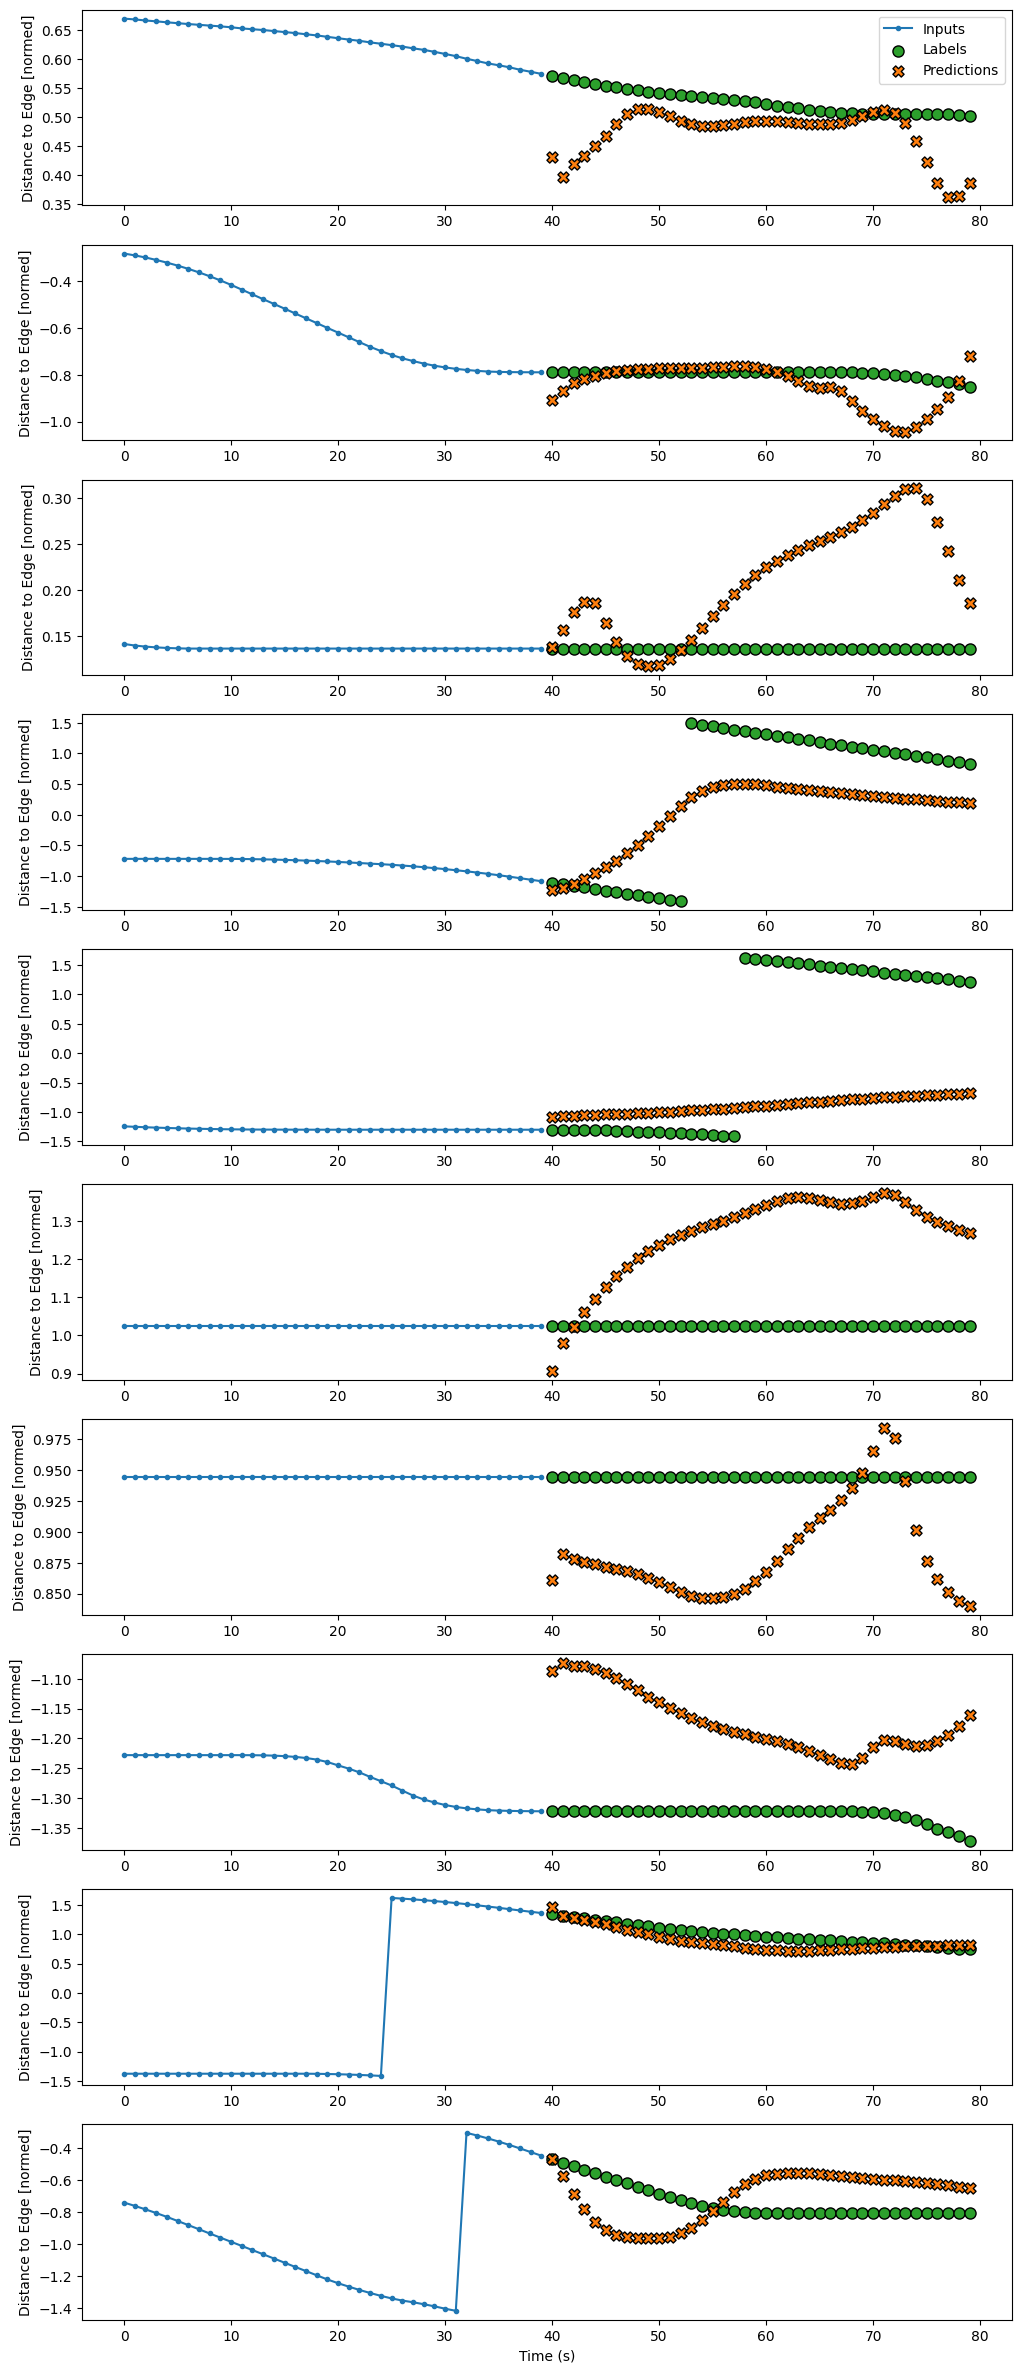

In [ ]:
w1.plot(test_ds_full, bigger_lstm_feedback, max_subplots=10)

# Model #6 Big LSTM layer, More Dense, More LSTM, Single-Shot Prediction

Doesn't work well: Dense layer seems to be messing it up

In [ ]:
complex_LSTM = keras.Sequential([
    layers.LSTM(32, return_sequences=True),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32),
    layers.Dense(64),
    layers.Dense(OUTPUT_STEPS),
    layers.Reshape([OUTPUT_STEPS, num_features])
])

In [ ]:
history = compile_and_fit(complex_LSTM, train_ds, val_ds)

Epoch 1/20
553/553 [==============================] - 54s 81ms/step - loss: 0.0732 - mean_absolute_error: 0.1729 - val_loss: 0.0164 - val_mean_absolute_error: 0.0992
Epoch 2/20
553/553 [==============================] - 42s 76ms/step - loss: 0.0134 - mean_absolute_error: 0.0873 - val_loss: 0.0102 - val_mean_absolute_error: 0.0758
Epoch 3/20
553/553 [==============================] - 42s 75ms/step - loss: 0.0125 - mean_absolute_error: 0.0797 - val_loss: 0.0082 - val_mean_absolute_error: 0.0630
Epoch 4/20
553/553 [==============================] - 42s 76ms/step - loss: 0.0075 - mean_absolute_error: 0.0638 - val_loss: 0.0071 - val_mean_absolute_error: 0.0577
Epoch 5/20
553/553 [==============================] - 42s 76ms/step - loss: 0.0219 - mean_absolute_error: 0.0896 - val_loss: 0.0136 - val_mean_absolute_error: 0.0838
Epoch 6/20
553/553 [==============================] - 42s 75ms/step - loss: 0.0058 - mean_absolute_error: 0.0543 - val_loss: 0.0066 - val_mean_absolute_error: 0.0542
Epoc

In [ ]:
complex_LSTM.evaluate(test_ds)

70/70 [==============================] - 1s 18ms/step - loss: 0.0079 - mean_absolute_error: 0.0611


[0.007853025570511818, 0.06112741678953171]

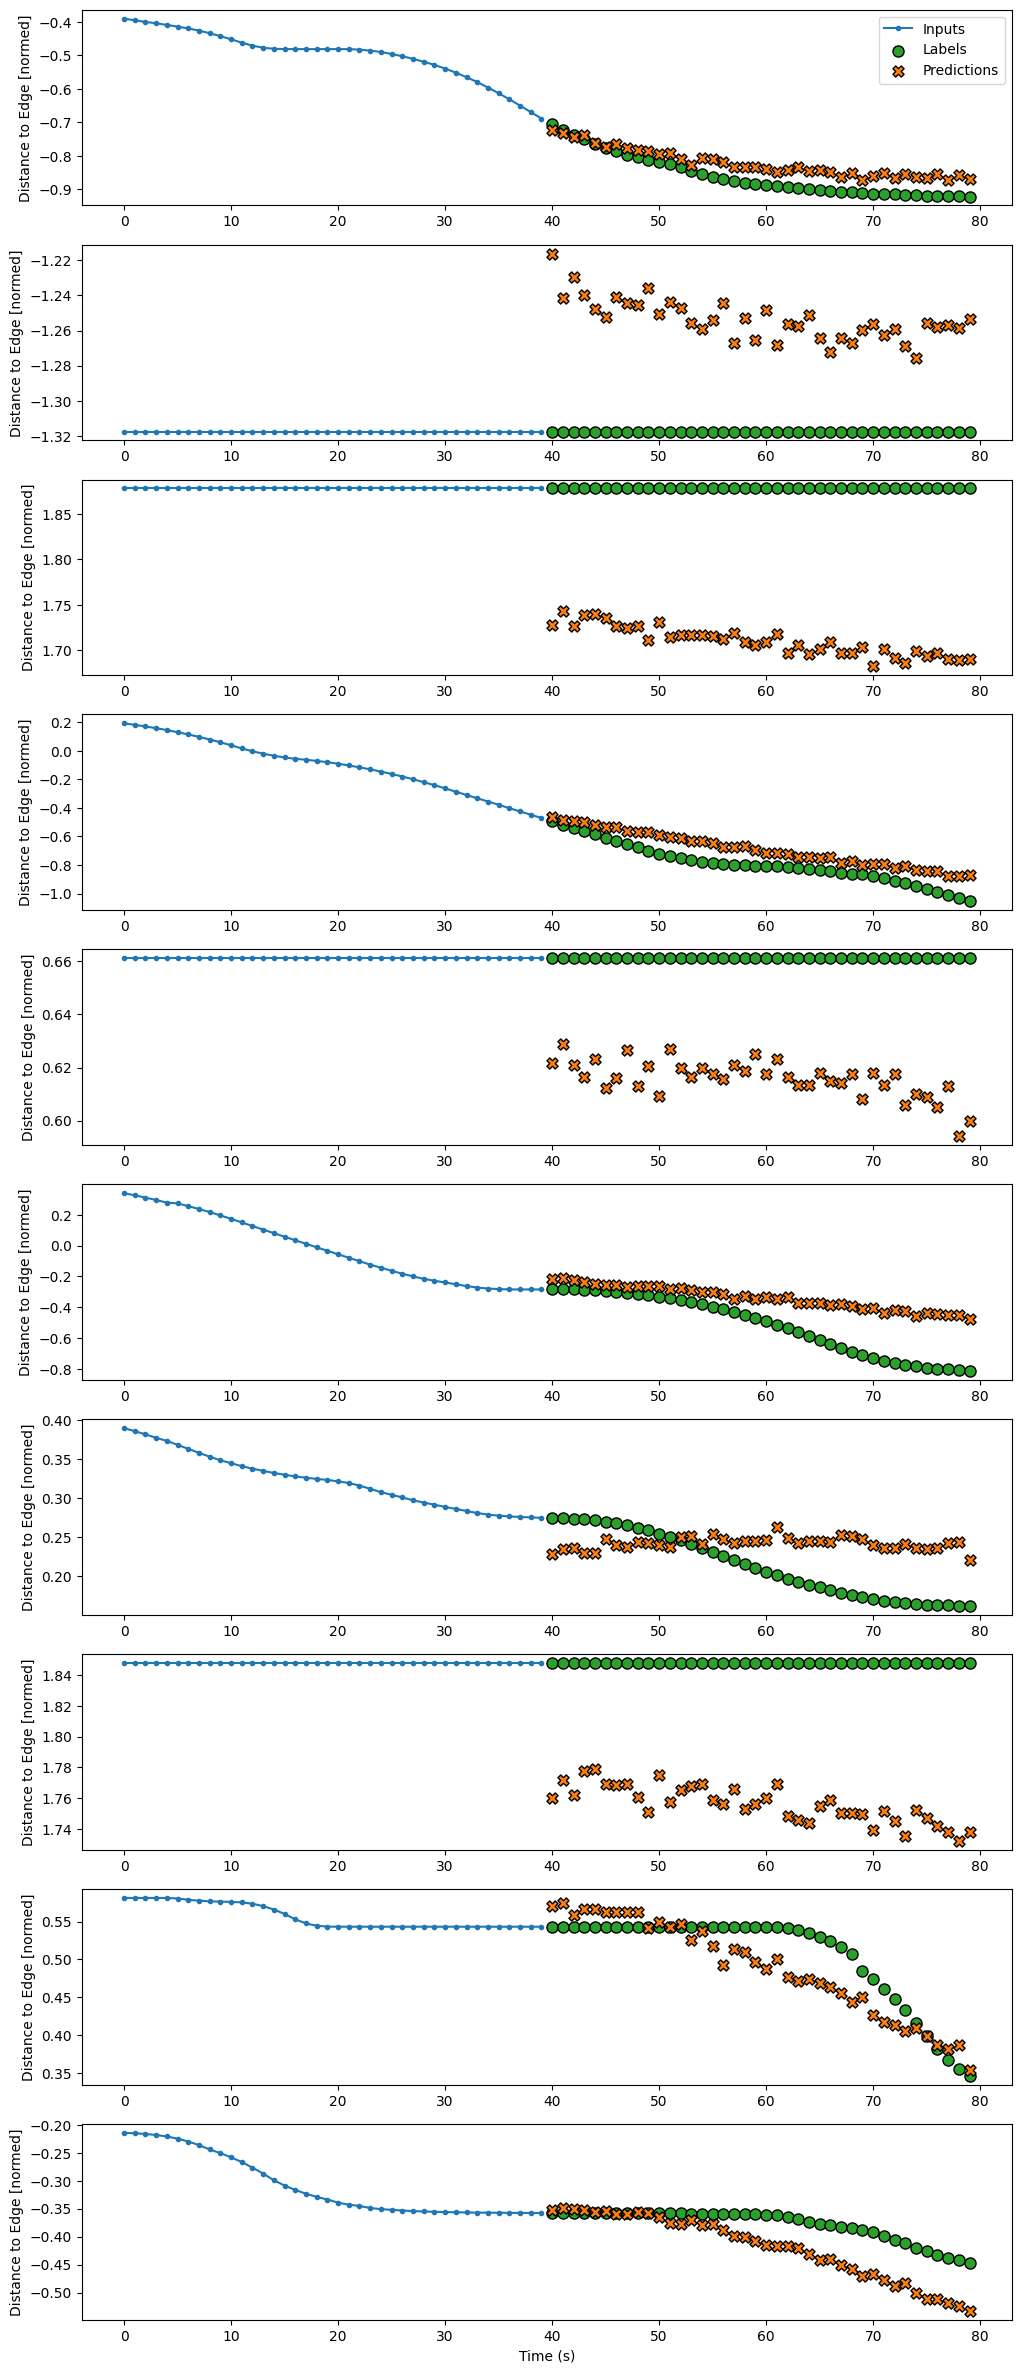

In [ ]:
w0.plot(test_ds, complex_LSTM, max_subplots=10)

# Model #7 Residual Network
Change from last input rather than generating a new output

In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

CPU times: user 22 ms, sys: 1.03 ms, total: 23 ms
Wall time: 25 ms


In [ ]:
history = compile_and_fit(residual_lstm, train_ds, val_ds)

Epoch 1/20
553/553 [==============================] - 34s 50ms/step - loss: 0.5584 - mean_absolute_error: 0.4984 - val_loss: 0.4834 - val_mean_absolute_error: 0.4352
Epoch 2/20
553/553 [==============================] - 28s 50ms/step - loss: 0.4717 - mean_absolute_error: 0.4407 - val_loss: 0.4683 - val_mean_absolute_error: 0.4313
Epoch 3/20
553/553 [==============================] - 29s 52ms/step - loss: 0.4611 - mean_absolute_error: 0.4316 - val_loss: 0.4630 - val_mean_absolute_error: 0.4194
Epoch 4/20
553/553 [==============================] - 28s 51ms/step - loss: 0.4591 - mean_absolute_error: 0.4295 - val_loss: 0.4621 - val_mean_absolute_error: 0.4190
Epoch 5/20
553/553 [==============================] - 29s 52ms/step - loss: 0.4574 - mean_absolute_error: 0.4276 - val_loss: 0.4626 - val_mean_absolute_error: 0.4181
Epoch 6/20
553/553 [==============================] - 29s 52ms/step - loss: 0.4577 - mean_absolute_error: 0.4278 - val_loss: 0.4617 - val_mean_absolute_error: 0.4344
Epoc

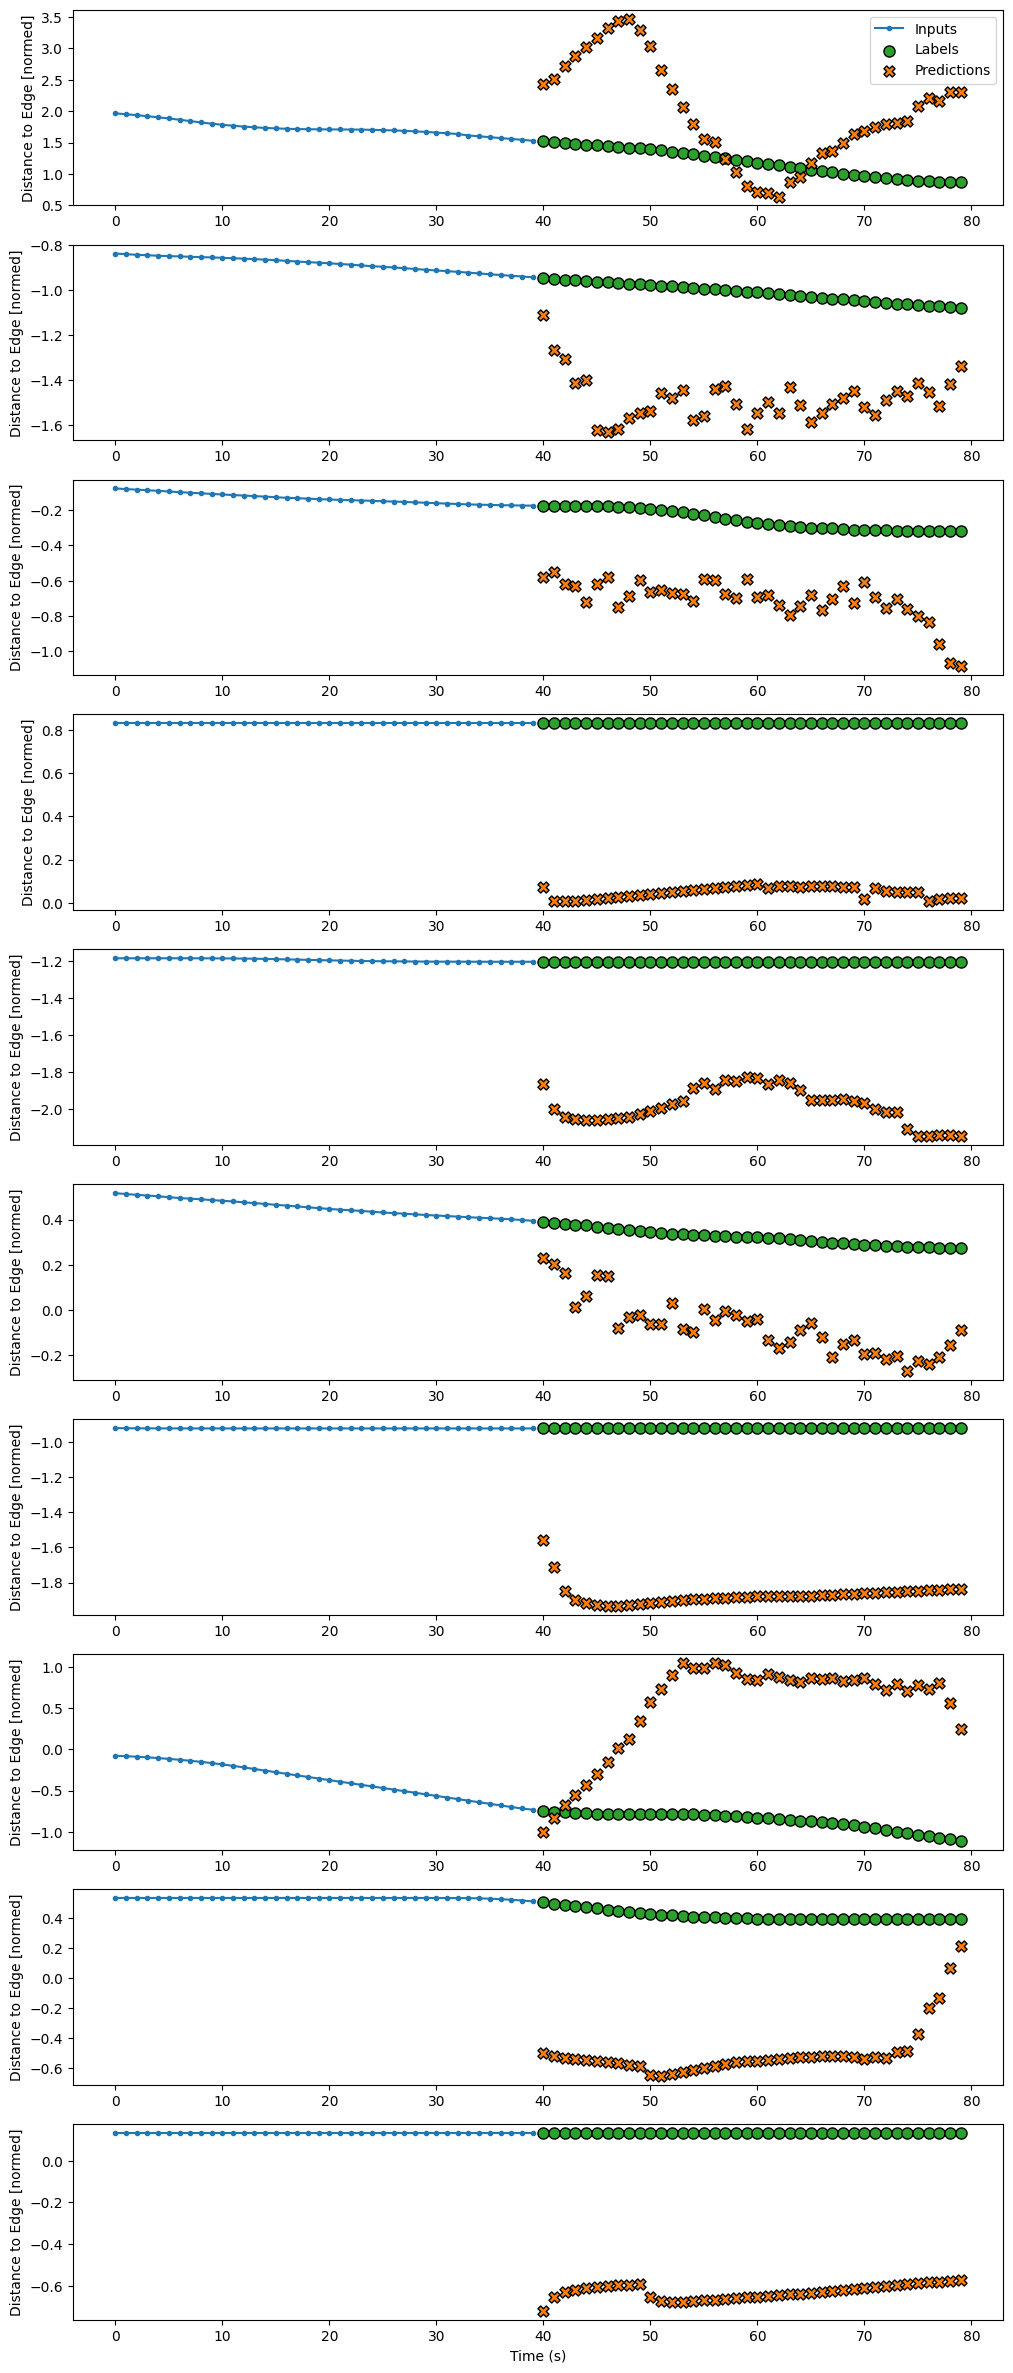

In [ ]:
w0.plot(test_ds, residual_lstm, max_subplots=10)

# Model #8: Big LSTM with Dropout
2 layers, both 64 cells, dropout layer in between
Adding dropout layer

In [ ]:
bigDenseDropLSTM = keras.Sequential([
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(64),

    layers.Dense(OUTPUT_STEPS * num_features,
                 kernel_initializer=tf.initializers.zeros()),
    layers.Reshape([OUTPUT_STEPS, num_features])
])

In [ ]:
history = compile_and_fit(bigDenseDropLSTM, train_ds, val_ds, patience=5)

Epoch 1/20
1578/1578 [==============================] - 83s 49ms/step - loss: 0.2669 - mean_absolute_error: 0.2566 - val_loss: 0.2521 - val_mean_absolute_error: 0.2362
Epoch 2/20
1578/1578 [==============================] - 88s 55ms/step - loss: 0.2224 - mean_absolute_error: 0.2241 - val_loss: 0.2283 - val_mean_absolute_error: 0.2157
Epoch 3/20
1578/1578 [==============================] - 78s 49ms/step - loss: 0.2084 - mean_absolute_error: 0.2077 - val_loss: 0.2212 - val_mean_absolute_error: 0.2048
Epoch 4/20
1578/1578 [==============================] - 83s 52ms/step - loss: 0.2006 - mean_absolute_error: 0.1985 - val_loss: 0.2166 - val_mean_absolute_error: 0.2005
Epoch 5/20
1578/1578 [==============================] - 77s 49ms/step - loss: 0.1953 - mean_absolute_error: 0.1921 - val_loss: 0.2117 - val_mean_absolute_error: 0.1952
Epoch 6/20
1578/1578 [==============================] - 79s 50ms/step - loss: 0.1915 - mean_absolute_error: 0.1876 - val_loss: 0.2068 - val_mean_absolute_error:

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


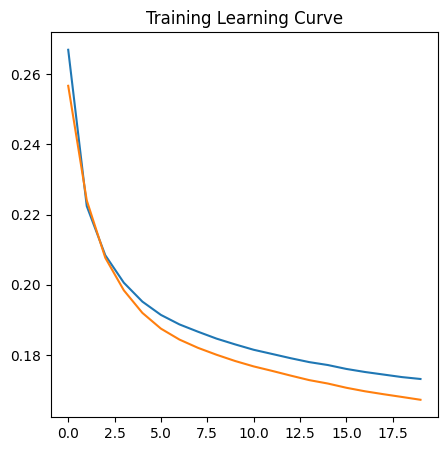

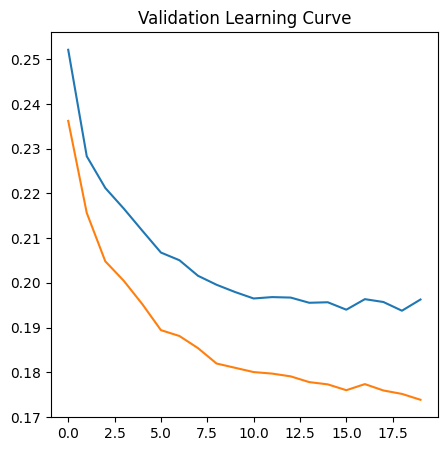

In [ ]:
# Plotting stats
plt.figure(figsize=(5, 5))
plt.title("Training Learning Curve")
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.show()

plt.figure(figsize=(5, 5))
plt.title("Validation Learning Curve")
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_mean_absolute_error'])
plt.show()

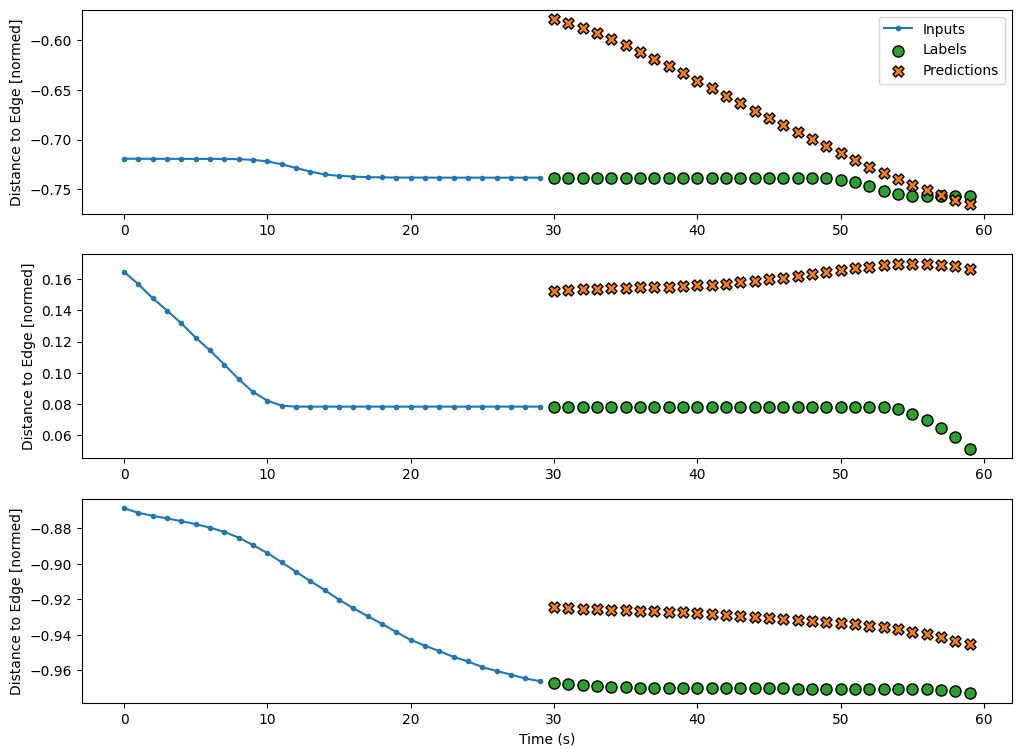

In [ ]:
w0.plot(test_ds, bigDenseDropLSTM)

In [ ]:
bigDenseDropLSTM.save("/content/drive/MyDrive/Colab Notebooks/model/bigDenseDropLSTM30Wind.keras")

# Findings

64 cell - Loss, Err, Eta (10) - 217s

64 cell LSTM, no Dest Reached - Loss = 0.209, Mean Abs Err = 0.211, Eta (50) - 369s

64 cell, no Dest Reached or edge - Loss = 0.359, Mean Abs Err = 0.336, Eta(10) - 493 s

64 cell no cat vars - Loss = 0.445, Mean Abs Err = 0.390, ETA(10) - 676 s

# Evaluating Model's Time Prediction Ability

In [ ]:
"""
Returns a chunk of a vehicle's time series that encapsulates when a vehicle sets off on a destination to when it reaches it, otherwise known as a trip

Params:
  List[list] ts : the time series of the vehicle to return a subset of
Ret:
  List[list] trip : a subset of the provided time series that represents a single trip of the vehicle
"""
def findTrip(ts):
  starts = []
  seenYes = False
  for i in range(len(ts)):
    el = ts[i]
    if el[-1] == 1 and seenYes == False:
      starts.append(i)
      seenYes = True
    elif el[-1] == 0 and seenYes == True:
      seenYes = False

  start = np.floor(np.random.rand(1) * (len(starts) - 2)).astype(int)[0]
  limit = len(starts) - 1
  while limit > 0 and starts[start + 1] - starts[start] < 160:
    start = np.floor(np.random.rand(1) * (len(starts) - 2)).astype(int)[0]
    limit -= 1

  if limit == 0:
    return -1

  try:
    return ts[starts[start]:starts[start + 1]]
  except IndexError:
    return -1


In [ ]:
"""
Finds the TL phases given the entire time series of a vehicle

Params:
  List[List] ts : the entire time series of a vehicle
Ret:
  Dict{List:int} phase : keys hold the one-hot encoded state and the values hold the time the state lasts for
"""
def findTLPhases(ts):
  # Translating from one-hot encoding to string representation of phase
  vocab = ['r', 'y', 'g', 'n']
  encode = layers.StringLookup(vocabulary=vocab, output_mode="one_hot")
  encodings = encode(vocab).numpy()
  str_to_onehot = {vocab[i]: encodings[i] for i in range(len(vocab))} # Translates from the string vocabulary of phases to the one-hot encoding
  onehot_to_str = {encodings[i]: vocab[i] for i in range(len(vocab))} # Translates from the string vocabulary of phases to the one-hot encoding

  time_in_red = 0
  time_in_curr_tl = 0 # The amount of time spent observing current TL
  prev, curr = 0, 1
  while curr < len(ts):
    # Check if staying at the same traffic light
    prev_dist_to_tl, curr_dist_to_tl = ts[prev][3], ts[curr][3]

    # Edge Case: there is no traffic light
    # Also makes sure that there is no traffic light switch
    if (prev_dist_to_tl != -1 and curr_dist_to_tl != -1) and prev_dist_to_tl - curr_dist_to_tl >= 0:
      time_in_curr_tl += 1 # Have been observing this traffic light for 1 time step
      state = onehot_to_str[ts[curr][19:24]]
      if state == 'r':
        time_in_red += 1
        if time_in_red > 6:
          return {{str_to_onehot['g']: 15, str_to_onehot['y']: 3, str_to_onehot['r']: 20}}
      else: # If the state is green, then most likely it is the shorter phase
        if time_in_red <= 6 and time_in_curr_tl > 6: # If we have been observing this TL for long enough
          return {str_to_onehot['g']: 10, str_to_onehot['y']: 3, str_to_onehot['r']: 3}
        else:
          time_ind_red = 0 # Don't think this will happen, but putting it here anyways
    # If there is a switch in traffic lights, reset the count
    else:
      time_in_curr_tl = 0
      time_in_red = 0

    prev += 1
    curr += 1

  # Default return the shorter phases
  return {str_to_onehot['g']: 10, str_to_onehot['y']: 3, str_to_onehot['r']: 3}

In [ ]:
"""
Given traffic light data we have when first encountered, extrapolate its phase and time left before phase switch at the start of the time series

Params:
  int tlTimeFound : the time step that the traffic light was found in. The units of time are in 0.5s increments
  List[] tlPhase : the one-hot encoded phase of the traffic light
  tlPhaseSwitchTime: the time left before the traffic light switches phase in units of 0.5s
  Dict{List:int} phase : keys hold the one-hot encoded state and the values hold the time the state lasts for
Ret:
  List[] tlInfoStart : a list holding first the phase of the traffic light at the start of the route and second the time left before the phase changes
"""
def getInitialTLState(tlTimeFound, tlPhase, tlPhaseSwitchTime, phase):
  phaseOrder = phase.keys()
  currPhaseInd = phaseOrder.index(tlPhase)

  while tlTimeFound > 0:
    tlTimeFound -= tlPhaseSwitchTime
    currPhaseInd = (currPhaseInd - 1) % 3 # Get the index of the current phase in the phaseOrder matrix
    tlPhase = phaseOrder[currPhaseInd] # Get the phase
    tlPhaseSwitchTime = phase[tlPhase] # Get the time left in this phase

  # The current time may be < 0, need to account for this
  tlPhaseSwitchTime += tlTimeFound # When the simulation starts, this is how much time there is left in the current phase

  return [phase, tlPhaseSwitchTime]

In [ ]:
"""
Returns the phase and time left to switch for a traffic light at a given time

Params:
  int time : the current time in units of 0.5s
  List[] initialState : list containing the phase and the time left to a phase switch of a Traffic Light at the start of the simulation
Ret:
  List[] tlCurrState : the current phase and time left to a phase switch for the given TL
"""
def getCurrTLState(time, initialState):
  pass

In [ ]:
"""
Returns all the traffic lights and the distance they are along the route, counting from the start of the route, in a given time series

Params:
  List[List] ts : the full time series of a vehicle starting and finishing a route
  Dict{List:int} phase : keys hold the one-hot encoded state and the values hold the time the state lasts for
Ret:
  Dict{float:List[]} tls: a dictionary where the keys are the distance from the destination from where the vehicle first detects the traffic light
    and the values are the phases and time left to switch that the traffic light starts at in the beginning of the time series
"""
def getTlSeries(ts, phase):
  tls = {}

  # Finding all traffic lights
  prev, curr = 0, 1
  while curr < len(ts):
    prev_dist_to_tl, curr_dist_to_tl = ts[prev][3], ts[curr][3]

    # Check if there is a switch in traffic lights. If so, record it
    if curr_dist_to_tl - prev_dist_to_tl > 0:
      dist_to_dest = ts[curr][18]

      curr_TL_phase = ts[curr][19:24]
      curr_TL_time_phase_switch = ts[curr][4]
      tlInfoStart = getInitialTLState(curr, curr_TL_phase, curr_TL_time_phase_switch * 2, phase)

      tls[dist_to_dest] = tlInfoStart

    prev += 1
    curr += 1

  return tls

In [ ]:
"""
Given a model and input time series, return when the vehicle will reach its destination

Params:
  tf.keras.Model model : The Tensorflow model used to predict
  list[list] input : the time series for the vehicle that will be fed into the model
  list[list] labels : the correct labels for the time series. Used for supplementing inputs to allow the model to keep making predictions
  WindowGenerator window : If not all labels are generated, will find the missing labels from here
  int patience : the number of times the model will make a prediction before the process is terminated
Ret:
  float eta : the estiamated time of arrival in units of each time step in the array
  list[list] predicted_ts : the predicted time series trajectory of the vehicle
"""
def predictEta(model, input, labels=None, window=None, patience=30):
  if window is not None:
    # Finding features that will be missing in model prediction
    missing_labels = [label for label in window.all_labels if label not in window.label_columns]
    wind_size = window.label_width
  reached_dist = min(labels[:, 18])

  # Initial prediction before looping
  curr_pred_wind = model(np.array([input])).numpy()
  dist = curr_pred_wind[0, :, 18]
  predicted_ts = curr_pred_wind[0]

  while patience > 0 and len(dist[dist <= reached_dist]) == 0: # Setting an arbitrary threshold for saying "destination reached"
    # Supplementing predicted window with data
    if window is not None:
      frame = 30 - patience # The current labels frame we are on
      if (frame + 1) * wind_size > len(labels): # If prediction is going on longer than expected, feeding repeat data from the last chunk (will have to change for traffic light states)
        supplement_slice = slice(len(labels) - wind_size, None)
      else:
        supplement_slice = slice(frame * wind_size, (frame + 1) * wind_size)
      supplement = np.concatenate([labels[supplement_slice, window.column_indices[label]] if type(window.column_indices[label]) is not int else
                                   labels[supplement_slice, slice(window.column_indices[label], window.column_indices[label] + 1)] for label in missing_labels], axis=-1)

      curr_pred_wind = np.append(curr_pred_wind, np.array([supplement]), axis=-1)

    # Predicting
    curr_pred_wind = model(curr_pred_wind).numpy()

    dist = curr_pred_wind[0, :, 18]
    predicted_ts = np.append(predicted_ts, curr_pred_wind[0], axis=0)
    patience -= 1

  # Finding ETA
  ind_reached = 0
  while ind_reached < len(dist):
    if dist[ind_reached] <= reached_dist:
      break
    ind_reached += 1
  sub_time = len(dist) - ind_reached - 1# Time to subtract from total

  eta = len(predicted_ts) - sub_time + 80 # Taking into account the 80 time steps from the input

  return eta, predicted_ts

In [ ]:
"""
Function to test the ETA prediction of the model.
Picks specified number of random time series, then prints the predicted and actual ETA in both 0.5s units and 1s units
Plots the results.

Params:
  tf.keras.Model model : the model used for predictions
  int numsamples : number of samples to test the model on
  bool plot : Whether to plot the results or not
  bool verbose : whether to show results after every sample
Ret:
  None
"""
def testEta(model, num_samples=10, window=None, plot=True, verbose=True):
  chosen_ts = np.rint(np.random.rand(num_samples) * 549).astype(int)
  errors = []
  count = 1
  for el in chosen_ts:
    t = findTrip(all_data[el])
    while type(t) is int: # If the function returns an error (unable to find a time frame that has a wide enough window)
      ind = np.rint(np.random.rand(1) * 549).astype(int)[0]
      t = findTrip(all_data[ind])
    input_t = t[:80]
    label_t = t[80:]

    eta, predicted_ts = predictEta(model, input_t, label_t, window)
    abs_error = abs(eta - len(t))
    errors.append(abs_error)

    if verbose:
      print(f"Results for vehicle {count}:")
      print(f"Predicted ETA (Units: 0.5s): {eta}\nReal Eta (Units: 0.5s): {len(t)}\n")
      print(f"Predicted ETA (Units: 1.0s): {eta / 2}\nReal Eta (Units: 1.0s): {len(t) / 2}\n")
      print(f"Abs Error (Units: 0.5s): {abs_error}\nAbs Error (Units: 1.0s): {abs_error / 2}")

    if plot:
      plt.figure(figsize=(16, 3))
      plt.title(f"Time Series Prediction for Veh ID {el}")
      plt.ylabel(f"Distance to Destination (normed)")
      plt.xlabel(f"Time (Units: 0.5s)")
      plt.plot(np.arange(80), input_t[:, 3])
      plt.scatter(np.arange(80, 80 + len(label_t)), label_t[:, 3], marker="o")
      plt.scatter(np.arange(80, len(predicted_ts) + 80), predicted_ts[:, 3], marker="x")
      plt.show()

    if verbose:
      print("\n\n")
    count += 1

  mean_abs_error = sum(errors) / len(errors)
  print(("-" * 10) + f" RESULTS FOR {count - 1} VEHICLES" + ("-" * 10))
  print(f"Mean Absolute Error (Units: 0.5s): {mean_abs_error}\nMean Absolute Error (Units: 1.0s): {mean_abs_error / 2}")

In [ ]:
for i in range(len(labels)):
  print(i, labels[i])

0 Speed
1 Max Speed
2 Acceleration
3 Traffic Light Distance
4 Traffic Light Time to Switch
5 Number of Vehicles to Traffic Light
6 Number of Leading Vehicles
7 Leading Vehicles Average Gap
8 Leading Vehicles Average Speed
9 Leading Vehicles Average Acceleration
10 Number of Right Lane Vehicles
11 Right Lane Average Gap
12 Right Lane Average Speed
13 Right Lane Average Acceleration
14 Number of Left Lane Vehicles
15 Left Lane Average Gap
16 Left Lane Average Speed
17 Left Lane Average Acceleration
18 Distance to Edge
19 Traffic Light State
20 Destination Edge
21 Destination Reached


In [ ]:
bigger_LSTM = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/model/biggerLSTM_80sWind_NoCatVars.keras')

In [ ]:
w1 = WindowGenerator(80, 80, 80, 20, train_ts, validate_ts, test_ts, labels, labels[:-3])

Results for vehicle 1:
Predicted ETA (Units: 0.5s): 1116
Real Eta (Units: 0.5s): 463

Predicted ETA (Units: 1.0s): 558.0
Real Eta (Units: 1.0s): 231.5

Abs Error (Units: 0.5s): 653
Abs Error (Units: 1.0s): 326.5


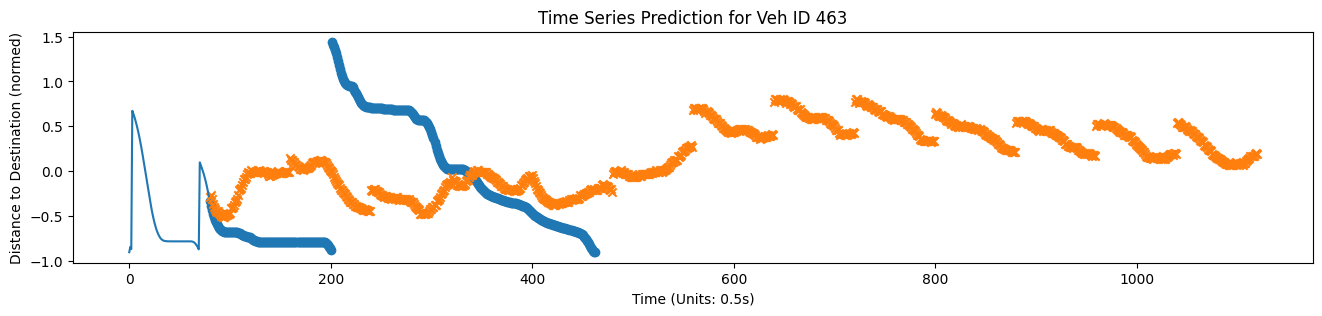




Results for vehicle 2:
Predicted ETA (Units: 0.5s): 772
Real Eta (Units: 0.5s): 476

Predicted ETA (Units: 1.0s): 386.0
Real Eta (Units: 1.0s): 238.0

Abs Error (Units: 0.5s): 296
Abs Error (Units: 1.0s): 148.0


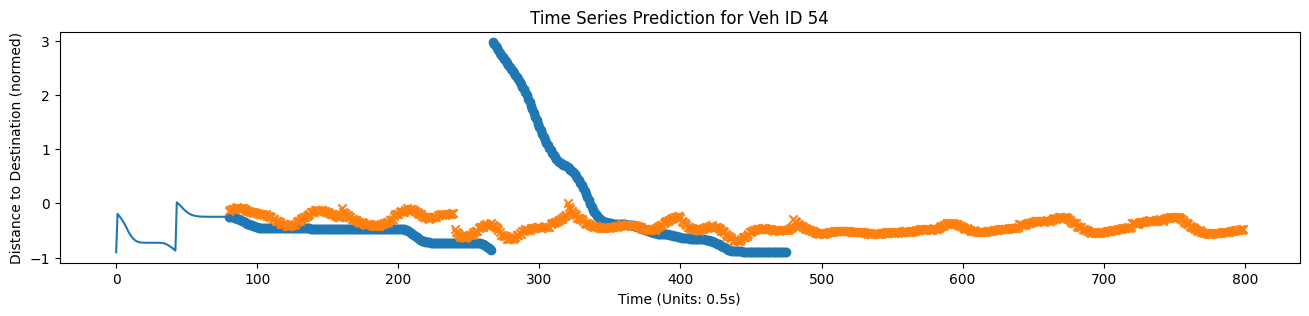




Results for vehicle 3:
Predicted ETA (Units: 0.5s): 1825
Real Eta (Units: 0.5s): 306

Predicted ETA (Units: 1.0s): 912.5
Real Eta (Units: 1.0s): 153.0

Abs Error (Units: 0.5s): 1519
Abs Error (Units: 1.0s): 759.5


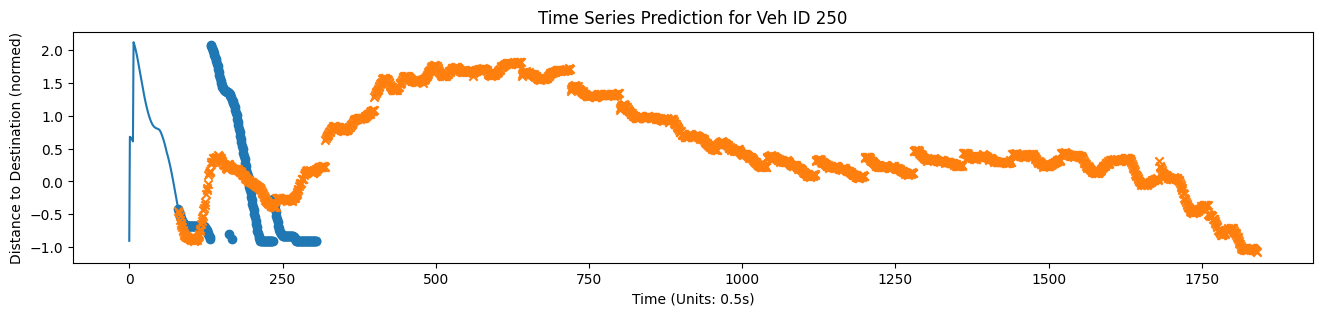




Results for vehicle 4:
Predicted ETA (Units: 0.5s): 161
Real Eta (Units: 0.5s): 193

Predicted ETA (Units: 1.0s): 80.5
Real Eta (Units: 1.0s): 96.5

Abs Error (Units: 0.5s): 32
Abs Error (Units: 1.0s): 16.0


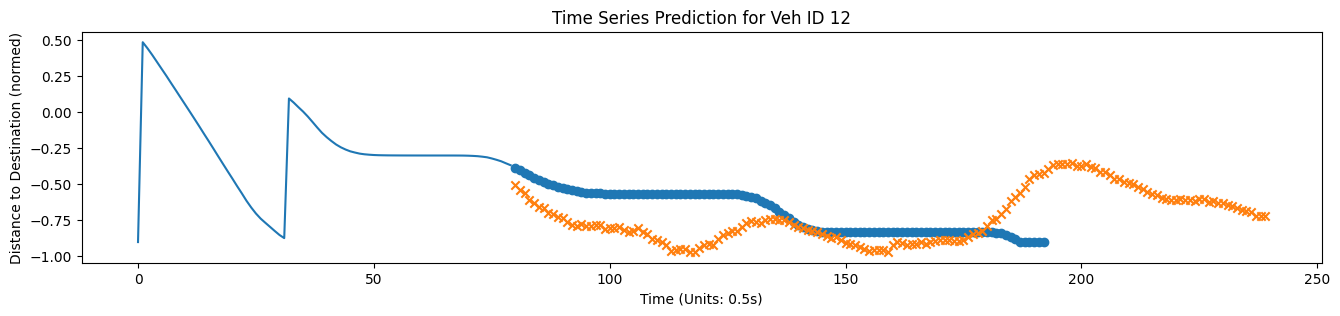




Results for vehicle 5:
Predicted ETA (Units: 0.5s): 497
Real Eta (Units: 0.5s): 504

Predicted ETA (Units: 1.0s): 248.5
Real Eta (Units: 1.0s): 252.0

Abs Error (Units: 0.5s): 7
Abs Error (Units: 1.0s): 3.5


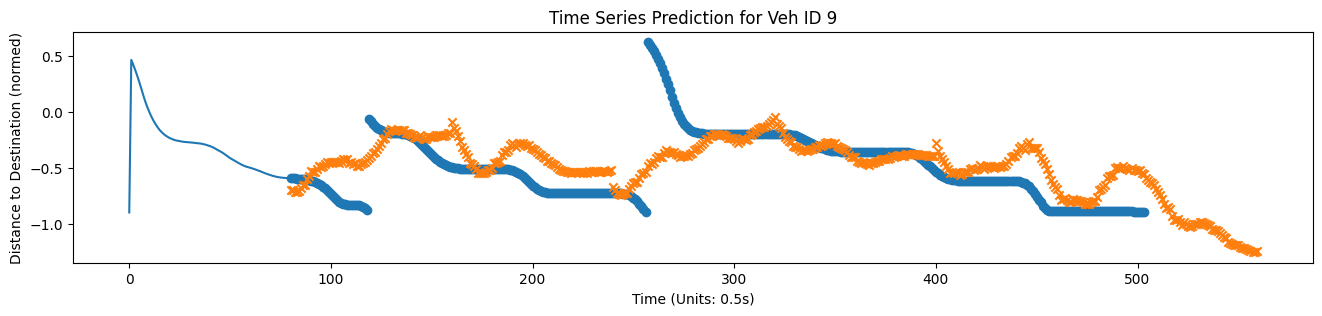




Results for vehicle 6:
Predicted ETA (Units: 0.5s): 2561
Real Eta (Units: 0.5s): 292

Predicted ETA (Units: 1.0s): 1280.5
Real Eta (Units: 1.0s): 146.0

Abs Error (Units: 0.5s): 2269
Abs Error (Units: 1.0s): 1134.5


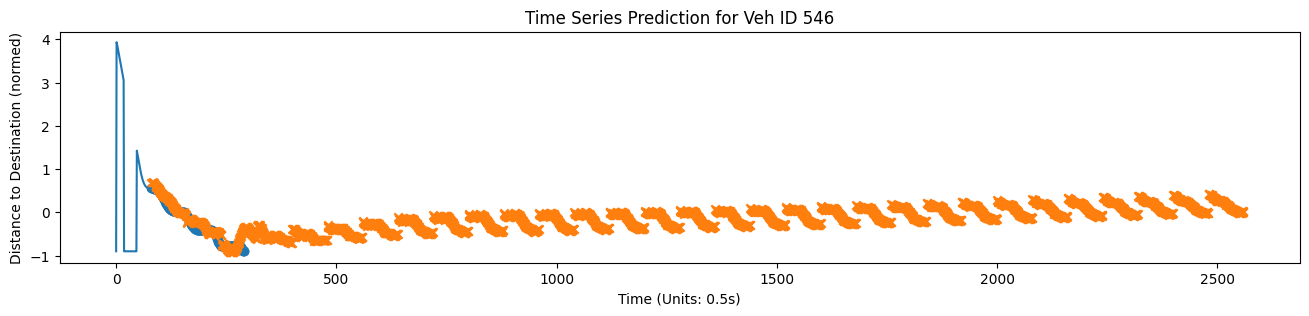




Results for vehicle 7:
Predicted ETA (Units: 0.5s): 1588
Real Eta (Units: 0.5s): 588

Predicted ETA (Units: 1.0s): 794.0
Real Eta (Units: 1.0s): 294.0

Abs Error (Units: 0.5s): 1000
Abs Error (Units: 1.0s): 500.0


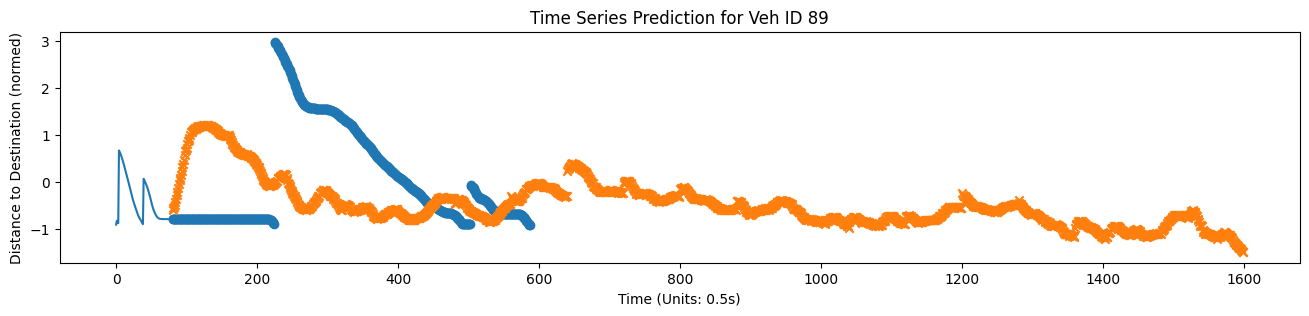




Results for vehicle 8:
Predicted ETA (Units: 0.5s): 2561
Real Eta (Units: 0.5s): 511

Predicted ETA (Units: 1.0s): 1280.5
Real Eta (Units: 1.0s): 255.5

Abs Error (Units: 0.5s): 2050
Abs Error (Units: 1.0s): 1025.0


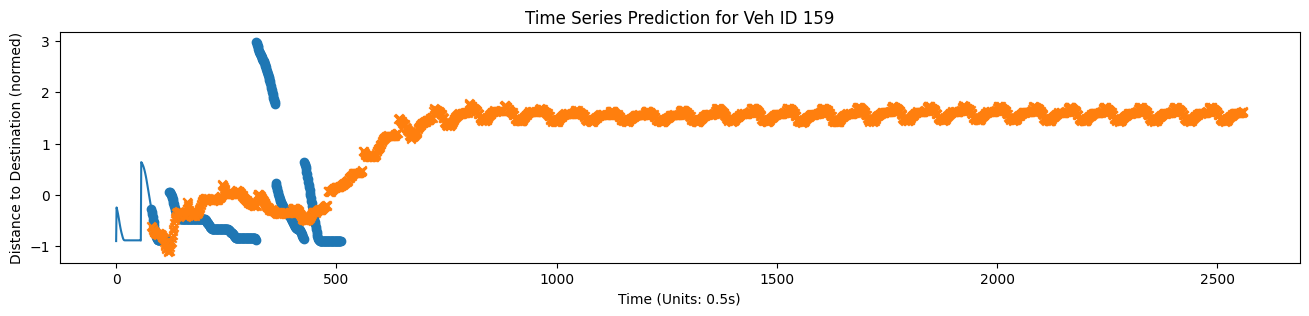




Results for vehicle 9:
Predicted ETA (Units: 0.5s): 295
Real Eta (Units: 0.5s): 257

Predicted ETA (Units: 1.0s): 147.5
Real Eta (Units: 1.0s): 128.5

Abs Error (Units: 0.5s): 38
Abs Error (Units: 1.0s): 19.0


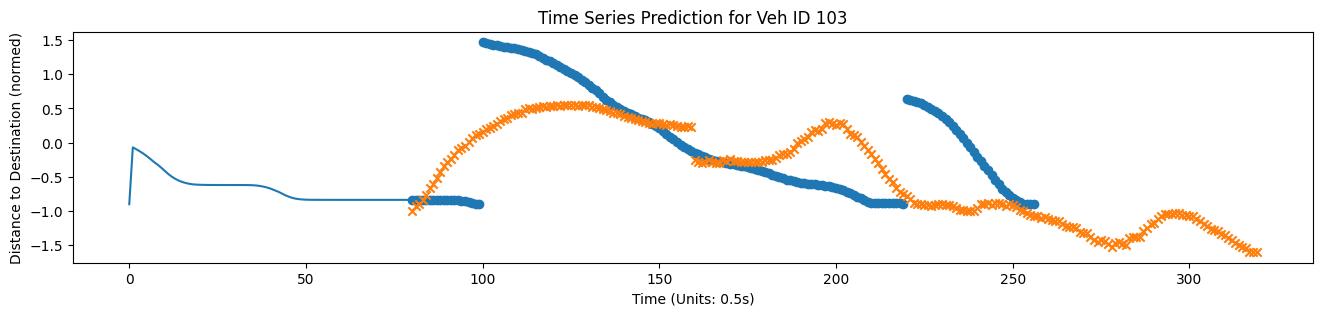




Results for vehicle 10:
Predicted ETA (Units: 0.5s): 853
Real Eta (Units: 0.5s): 310

Predicted ETA (Units: 1.0s): 426.5
Real Eta (Units: 1.0s): 155.0

Abs Error (Units: 0.5s): 543
Abs Error (Units: 1.0s): 271.5


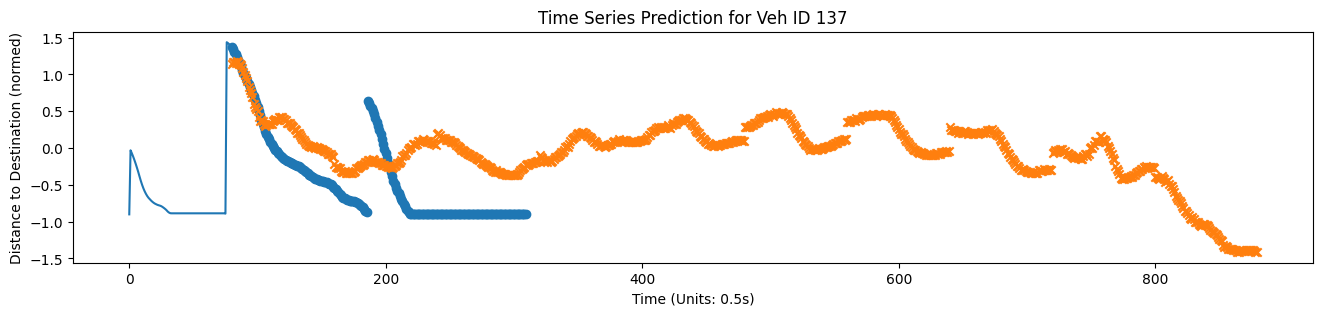




Results for vehicle 11:
Predicted ETA (Units: 0.5s): 952
Real Eta (Units: 0.5s): 387

Predicted ETA (Units: 1.0s): 476.0
Real Eta (Units: 1.0s): 193.5

Abs Error (Units: 0.5s): 565
Abs Error (Units: 1.0s): 282.5


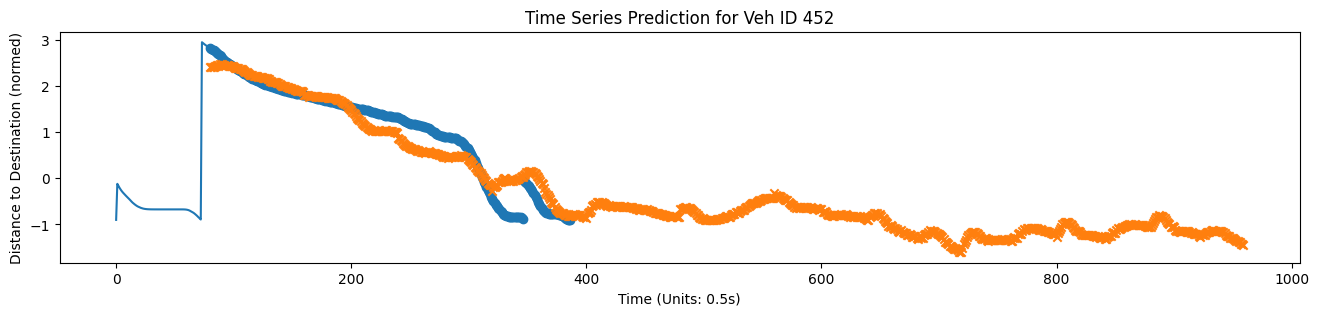




Results for vehicle 12:
Predicted ETA (Units: 0.5s): 1354
Real Eta (Units: 0.5s): 607

Predicted ETA (Units: 1.0s): 677.0
Real Eta (Units: 1.0s): 303.5

Abs Error (Units: 0.5s): 747
Abs Error (Units: 1.0s): 373.5


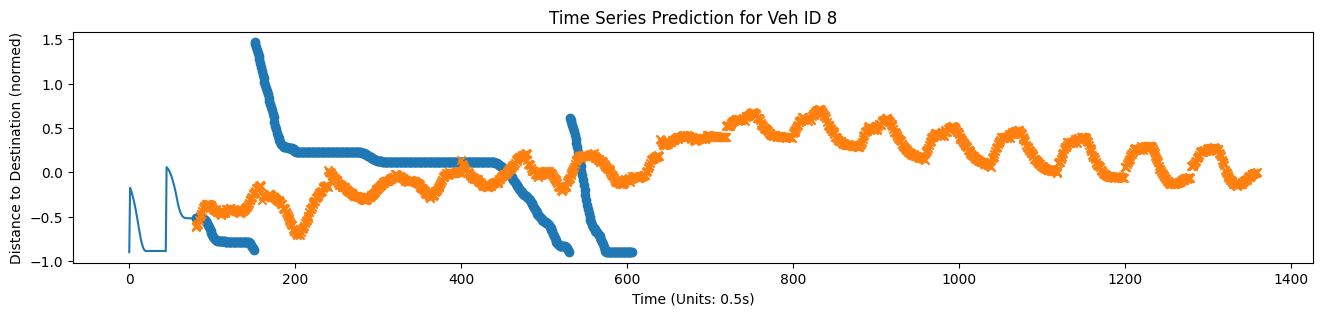




Results for vehicle 13:
Predicted ETA (Units: 0.5s): 2561
Real Eta (Units: 0.5s): 327

Predicted ETA (Units: 1.0s): 1280.5
Real Eta (Units: 1.0s): 163.5

Abs Error (Units: 0.5s): 2234
Abs Error (Units: 1.0s): 1117.0


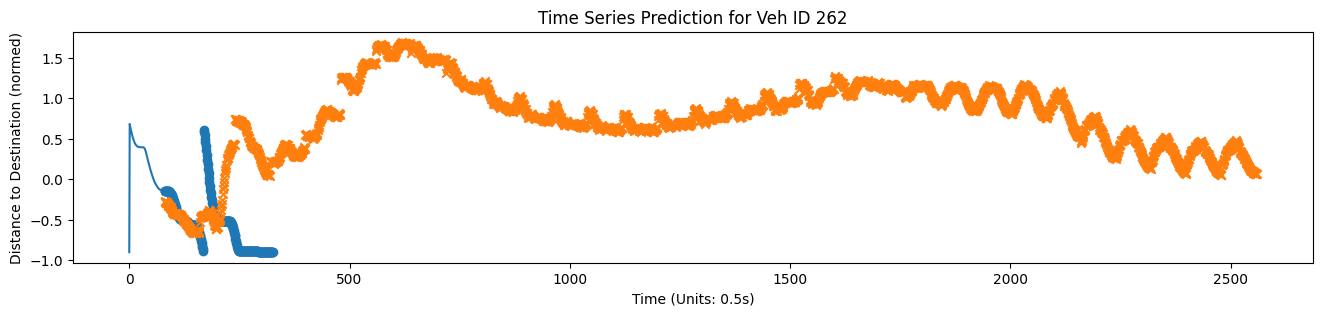




Results for vehicle 14:
Predicted ETA (Units: 0.5s): 2561
Real Eta (Units: 0.5s): 602

Predicted ETA (Units: 1.0s): 1280.5
Real Eta (Units: 1.0s): 301.0

Abs Error (Units: 0.5s): 1959
Abs Error (Units: 1.0s): 979.5


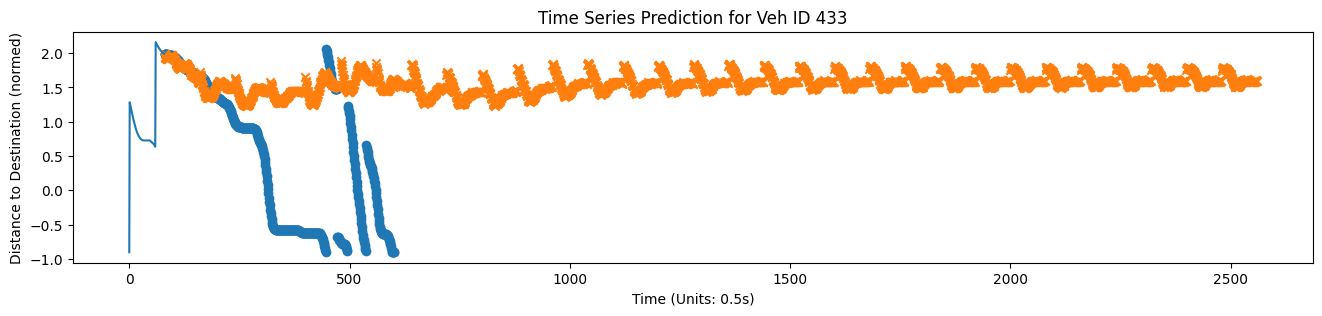




Results for vehicle 15:
Predicted ETA (Units: 0.5s): 1082
Real Eta (Units: 0.5s): 351

Predicted ETA (Units: 1.0s): 541.0
Real Eta (Units: 1.0s): 175.5

Abs Error (Units: 0.5s): 731
Abs Error (Units: 1.0s): 365.5


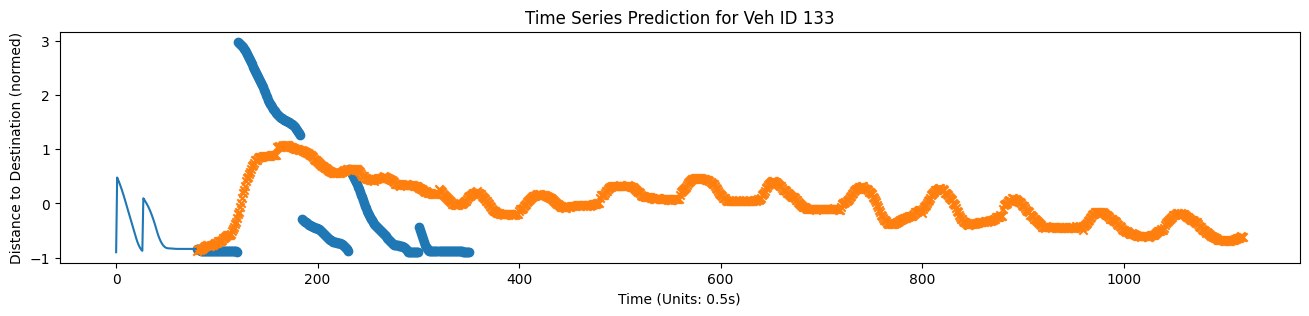




Results for vehicle 16:
Predicted ETA (Units: 0.5s): 2561
Real Eta (Units: 0.5s): 297

Predicted ETA (Units: 1.0s): 1280.5
Real Eta (Units: 1.0s): 148.5

Abs Error (Units: 0.5s): 2264
Abs Error (Units: 1.0s): 1132.0


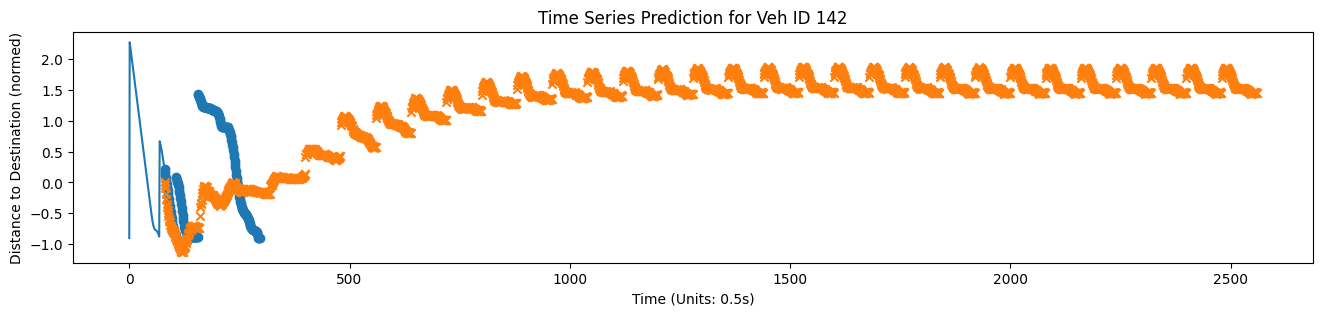




Results for vehicle 17:
Predicted ETA (Units: 0.5s): 1575
Real Eta (Units: 0.5s): 618

Predicted ETA (Units: 1.0s): 787.5
Real Eta (Units: 1.0s): 309.0

Abs Error (Units: 0.5s): 957
Abs Error (Units: 1.0s): 478.5


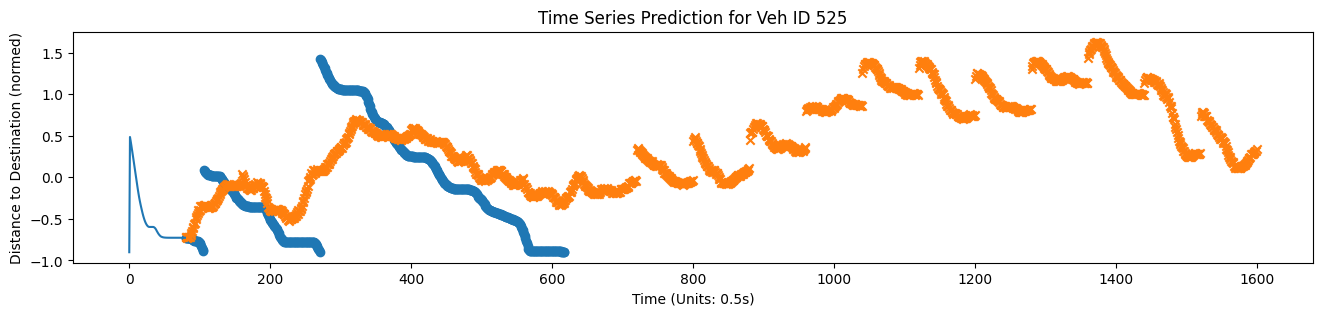




Results for vehicle 18:
Predicted ETA (Units: 0.5s): 2561
Real Eta (Units: 0.5s): 292

Predicted ETA (Units: 1.0s): 1280.5
Real Eta (Units: 1.0s): 146.0

Abs Error (Units: 0.5s): 2269
Abs Error (Units: 1.0s): 1134.5


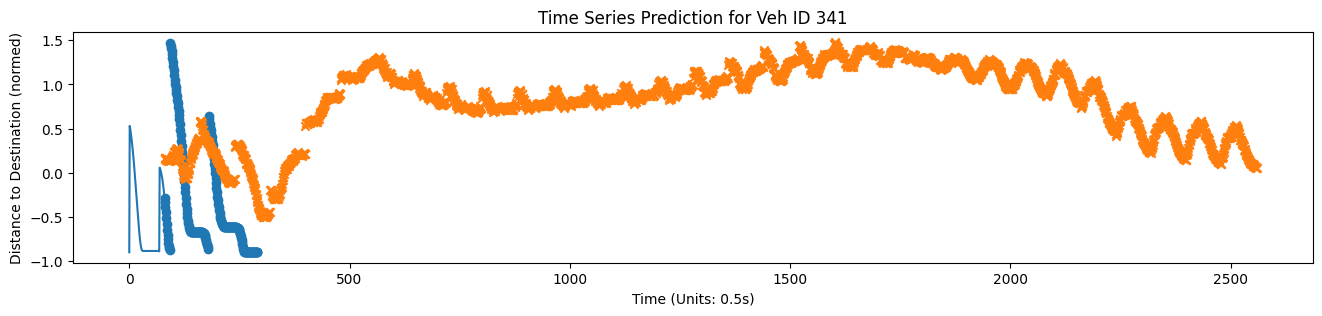




Results for vehicle 19:
Predicted ETA (Units: 0.5s): 2561
Real Eta (Units: 0.5s): 361

Predicted ETA (Units: 1.0s): 1280.5
Real Eta (Units: 1.0s): 180.5

Abs Error (Units: 0.5s): 2200
Abs Error (Units: 1.0s): 1100.0


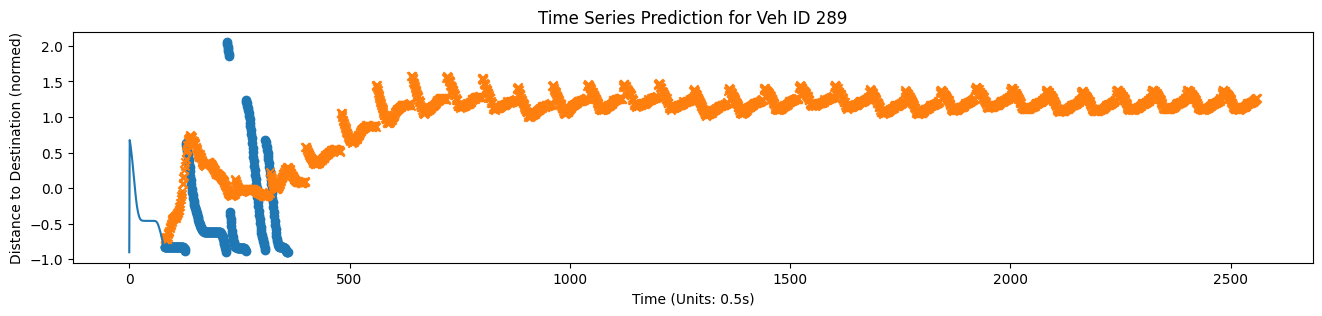




Results for vehicle 20:
Predicted ETA (Units: 0.5s): 2561
Real Eta (Units: 0.5s): 364

Predicted ETA (Units: 1.0s): 1280.5
Real Eta (Units: 1.0s): 182.0

Abs Error (Units: 0.5s): 2197
Abs Error (Units: 1.0s): 1098.5


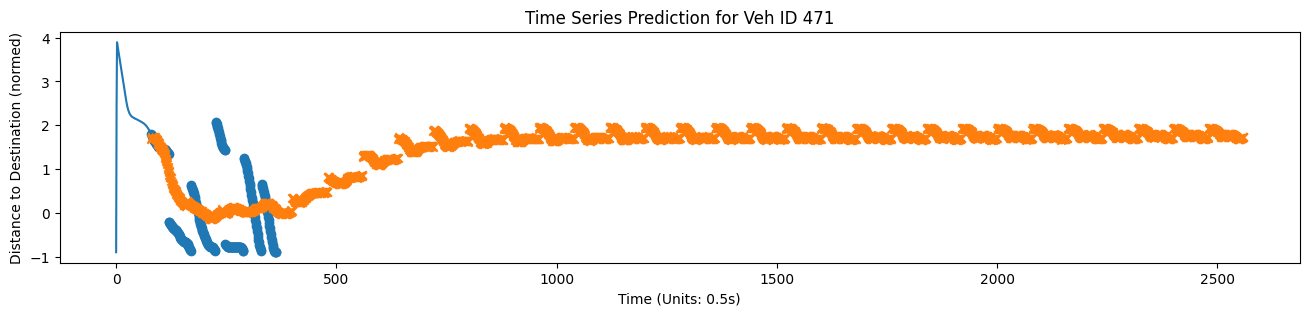




---------- RESULTS FOR 20 VEHICLES----------
Mean Absolute Error (Units: 0.5s): 1226.5
Mean Absolute Error (Units: 1.0s): 613.25


In [ ]:
# Running test function
testEta(bigger_LSTM, num_samples=20, window=w1, plot=True, verbose=True)

In [ ]:
for el in labels:
  print(el)

Speed
Max Speed
Acceleration
Traffic Light Distance
Traffic Light Time to Switch
Number of Vehicles to Traffic Light
Number of Leading Vehicles
Leading Vehicles Average Gap
Leading Vehicles Average Speed
Leading Vehicles Average Acceleration
Number of Right Lane Vehicles
Right Lane Average Gap
Right Lane Average Speed
Right Lane Average Acceleration
Number of Left Lane Vehicles
Left Lane Average Gap
Left Lane Average Speed
Left Lane Average Acceleration
Distance to Edge
Traffic Light State
Destination Edge
Destination Reached


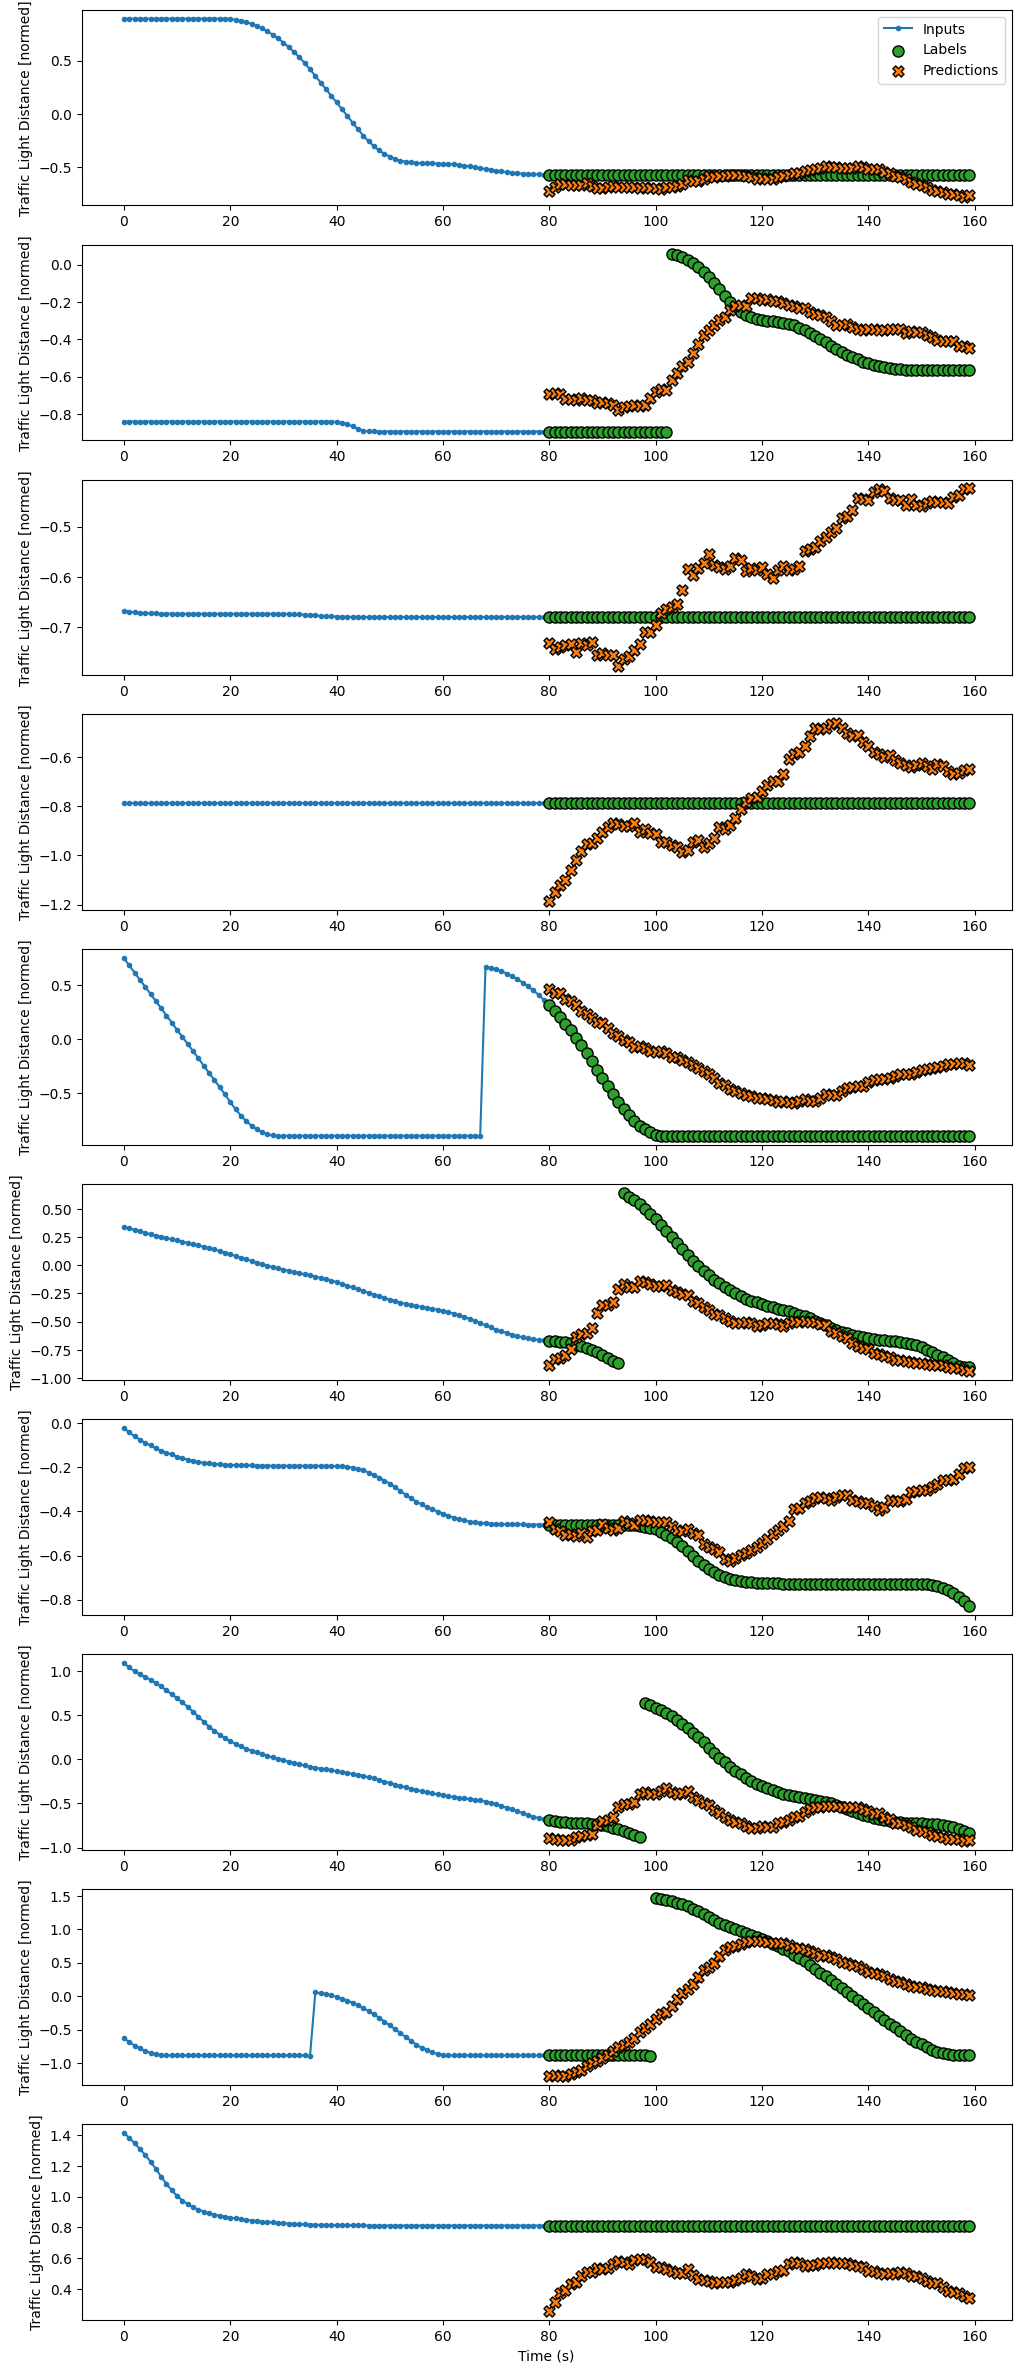

In [ ]:
w1.plot(train_ds, bigger_LSTM, plot_col="Traffic Light Distance", max_subplots=10)